# Search for AIMA 4th edition

Implementation of search algorithms and search problems for AIMA.

# Problems and Nodes

We start by defining the abstract class for a `Problem`; specific problem domains will subclass this. To make it easier for algorithms that use a heuristic evaluation function, `Problem` has a default `h` function (uniformly zero), and subclasses can define their own default `h` function.

We also define a `Node` in a search tree, and some functions on nodes: `expand` to generate successors; `path_actions` and `path_states`  to recover aspects of the path from the node.  

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import heapq
import math
import sys
from collections import defaultdict, deque, Counter
from itertools import combinations


class Problem(object):
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default heuristic is 0 and the default action cost is 1 for all states.
    When yiou create an instance of a subclass, specify `initial`, and `goal` states 
    (or give an `is_goal` method) and perhaps other keyword args for the subclass."""

    def __init__(self, initial=None, goal=None, **kwds): 
        self.__dict__.update(initial=initial, goal=goal, **kwds) 
        
    def actions(self, state):        raise NotImplementedError
    def result(self, state, action): raise NotImplementedError
    def is_goal(self, state):        return state == self.goal
    def action_cost(self, s, a, s1): return 1
    def h(self, node):               return 0
    
    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)
    

class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)

    def __repr__(self): return '<{}>'.format(self.state)
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): return self.path_cost < other.path_cost
    
    
failure = Node('failure', path_cost=math.inf) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=math.inf) # Indicates iterative deepening search was cut off.
    
    
def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.action_cost(s, action, s1)
        yield Node(s1, node, action, cost)
        

def path_actions(node):
    "The sequence of actions to get to this node."
    if node.parent is None:
        return []  
    return path_actions(node.parent) + [node.action]


def path_states(node):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None): 
        return []
    return path_states(node.parent) + [node.state]

# Problem Domains

Now we turn our attention to defining some problem domains as subclasses of `Problem`.

# Route Finding Problems

![](romania.jpg)

In a `RouteProblem`, the states are names of "cities" (or other locations), like `'A'` for Arad. The actions are also city names; `'Z'` is the action to move to city `'Z'`. The layout of cities is given by a separate data structure, a `Map`, which is a graph where there are vertexes (cities), links between vertexes, distances (costs) of those links (if not specified, the default is 1 for every link), and optionally the 2D (x, y) location of each city can be specified. A `RouteProblem` takes this `Map` as input and allows actions to move between linked cities. The default heuristic is straight-line distance to the goal, or is uniformly zero if locations were not given.

In [6]:
class RouteProblem(Problem):
    """A problem to find a route between locations on a `Map`.
    Create a problem with RouteProblem(start, goal, map=Map(...)}).
    States are the vertexes in the Map graph; actions are destination states."""
    
    def actions(self, state): 
        """The places neighboring `state`."""
        return self.map.neighbors[state]
    
    def result(self, state, action):
        """Go to the `action` place, if the map says that is possible."""
        return action if action in self.map.neighbors[state] else state
    
    def action_cost(self, s, action, s1):
        """The distance (cost) to go from s to s1."""
        return self.map.distances[s, s1]
    
    def h(self, node):
        "Straight-line distance between state and the goal."
        locs = self.map.locations
        return straight_line_distance(locs[node.state], locs[self.goal])
    
    
def straight_line_distance(A, B):
    "Straight-line distance between two points."
    return sum(abs(a - b)**2 for (a, b) in zip(A, B)) ** 0.5

In [7]:
class Map:
    """A map of places in a 2D world: a graph with vertexes and links between them. 
    In `Map(links, locations)`, `links` can be either [(v1, v2)...] pairs, 
    or a {(v1, v2): distance...} dict. Optional `locations` can be {v1: (x, y)} 
    If `directed=False` then for every (v1, v2) link, we add a (v2, v1) link."""

    def __init__(self, links, locations=None, directed=False):
        if not hasattr(links, 'items'): # Distances are 1 by default
            links = {link: 1 for link in links}
        if not directed:
            for (v1, v2) in list(links):
                links[v2, v1] = links[v1, v2]
        self.distances = links
        self.neighbors = multimap(links)
        self.locations = locations or defaultdict(lambda: (0, 0))

        
def multimap(pairs) -> dict:
    "Given (key, val) pairs, make a dict of {key: [val,...]}."
    result = defaultdict(list)
    for key, val in pairs:
        result[key].append(val)
    return result

In [8]:
# Some specific RouteProblems

romania = Map(
    {('O', 'Z'):  71, ('O', 'S'): 151, ('A', 'Z'): 75, ('A', 'S'): 140, ('A', 'T'): 118, 
     ('L', 'T'): 111, ('L', 'M'):  70, ('D', 'M'): 75, ('C', 'D'): 120, ('C', 'R'): 146, 
     ('C', 'P'): 138, ('R', 'S'):  80, ('F', 'S'): 99, ('B', 'F'): 211, ('B', 'P'): 101, 
     ('B', 'G'):  90, ('B', 'U'):  85, ('H', 'U'): 98, ('E', 'H'):  86, ('U', 'V'): 142, 
     ('I', 'V'):  92, ('I', 'N'):  87, ('P', 'R'): 97},
    {'A': ( 76, 497), 'B': (400, 327), 'C': (246, 285), 'D': (160, 296), 'E': (558, 294), 
     'F': (285, 460), 'G': (368, 257), 'H': (548, 355), 'I': (488, 535), 'L': (162, 379),
     'M': (160, 343), 'N': (407, 561), 'O': (117, 580), 'P': (311, 372), 'R': (227, 412),
     'S': (187, 463), 'T': ( 83, 414), 'U': (471, 363), 'V': (535, 473), 'Z': (92, 539)})


r0 = RouteProblem('A', 'A', map=romania)
r1 = RouteProblem('A', 'B', map=romania)
r2 = RouteProblem('N', 'L', map=romania)
r3 = RouteProblem('E', 'T', map=romania)
r4 = RouteProblem('O', 'M', map=romania)

# Queues

First-in-first-out and Last-in-first-out queues, and a `PriorityQueue`, which allows you to keep a collection of items, and continually remove from it the item with minimum `f(item)` score.

In [9]:
FIFOQueue = deque

LIFOQueue = list

class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x): 
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        for item in items:
            self.add(item)
         
    def add(self, item):
        """Add item to the queuez."""
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]
    
    def top(self): return self.items[0][1]

    def __len__(self): return len(self.items)

# Search Algorithms: Best-First

Best-first search with various *f(n)* functions gives us different search algorithms. Note that A\*, weighted A\* and greedy search can be given a heuristic function, `h`, but if `h` is not supplied they use the problem's default `h` function (if the problem does not define one, it is taken as *h(n)* = 0).

In [10]:
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure


def best_first_tree_search(problem, f):
    "A version of best_first_search without the `reached` table."
    frontier = PriorityQueue([Node(problem.initial)], key=f)
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            if not is_cycle(child):
                frontier.add(child)
    return failure


def g(n): return n.path_cost


def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + h(n))


def astar_tree_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n), with no `reached` table."""
    h = h or problem.h
    return best_first_tree_search(problem, f=lambda n: g(n) + h(n))


def weighted_astar_search(problem, h=None, weight=1.4):
    """Search nodes with minimum f(n) = g(n) + weight * h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + weight * h(n))

        
def greedy_bfs(problem, h=None):
    """Search nodes with minimum h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=h)


def uniform_cost_search(problem):
    "Search nodes with minimum path cost first."
    return best_first_search(problem, f=g)


def breadth_first_bfs(problem):
    "Search shallowest nodes in the search tree first; using best-first."
    return best_first_search(problem, f=len)


def depth_first_bfs(problem):
    "Search deepest nodes in the search tree first; using best-first."
    return best_first_search(problem, f=lambda n: -len(n))


def is_cycle(node, k=30):
    "Does this node form a cycle of length k or less?"
    def find_cycle(ancestor, k):
        return (ancestor is not None and k > 0 and
                (ancestor.state == node.state or find_cycle(ancestor.parent, k - 1)))
    return find_cycle(node.parent, k)



In [11]:
path_states(uniform_cost_search(r1)) # Lowest-cost path from Arab to Bucharest

['A', 'S', 'R', 'P', 'B']

# Other Search Algorithms

Here are the other search algorithms:

In [12]:
def breadth_first_search(problem):
    "Search shallowest nodes in the search tree first."
    node = Node(problem.initial)
    if problem.is_goal(problem.initial):
        return node
    frontier = FIFOQueue([node])
    reached = {problem.initial}
    while frontier:
        node = frontier.pop()
        for child in expand(problem, node):
            s = child.state
            if problem.is_goal(s):
                return child
            if s not in reached:
                reached.add(s)
                frontier.appendleft(child)
    return failure


def iterative_deepening_search(problem):
    "Do depth-limited search with increasing depth limits."
    for limit in range(1, sys.maxsize):
        result = depth_limited_search(problem, limit)
        if result != cutoff:
            return result
        
        
def depth_limited_search(problem, limit=10):
    "Search deepest nodes in the search tree first."
    frontier = LIFOQueue([Node(problem.initial)])
    result = failure
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        elif len(node) >= limit:
            result = cutoff
        elif not is_cycle(node):
            for child in expand(problem, node):
                frontier.append(child)
    return result


def depth_first_recursive_search(problem, node=None):
    if node is None: 
        node = Node(problem.initial)
    if problem.is_goal(node.state):
        return node
    elif is_cycle(node):
        return failure
    else:
        for child in expand(problem, node):
            result = depth_first_recursive_search(problem, child)
            if result:
                return result
        return failure

In [13]:
path_states(breadth_first_search(r1)) # Breadth-first: fewer steps, higher path cost

['A', 'S', 'F', 'B']

In [14]:
path_states(depth_first_recursive_search(r2))

['N', 'I', 'V', 'U', 'B', 'F', 'S', 'O', 'Z', 'A', 'T', 'L']

# Bidirectional Best-First Search

In [15]:
def bidirectional_best_first_search(problem_f, f_f, problem_b, f_b, terminated):
    node_f = Node(problem_f.initial)
    node_b = Node(problem_f.goal)
    frontier_f, reached_f = PriorityQueue([node_f], key=f_f), {node_f.state: node_f}
    frontier_b, reached_b = PriorityQueue([node_b], key=f_b), {node_b.state: node_b}
    solution = failure
    while frontier_f and frontier_b and not terminated(solution, frontier_f, frontier_b):
        def S1(node, f):
            return str(int(f(node))) + ' ' + str(path_states(node))
        print('Bi:', S1(frontier_f.top(), f_f), S1(frontier_b.top(), f_b))
        if f_f(frontier_f.top()) < f_b(frontier_b.top()):
            solution = proceed('f', problem_f, frontier_f, reached_f, reached_b, solution)
        else:
            solution = proceed('b', problem_b, frontier_b, reached_b, reached_f, solution)
    return solution

def inverse_problem(problem):
    if isinstance(problem, CountCalls):
        return CountCalls(inverse_problem(problem._object))
    else:
        inv = copy.copy(problem)
        inv.initial, inv.goal = inv.goal, inv.initial
        return inv

In [16]:
def bidirectional_uniform_cost_search(problem_f):
    def terminated(solution, frontier_f, frontier_b):
        n_f, n_b = frontier_f.top(), frontier_b.top()
        return g(n_f) + g(n_b) > g(solution)
    return bidirectional_best_first_search(problem_f, g, inverse_problem(problem_f), g, terminated)

def bidirectional_astar_search(problem_f):
    def terminated(solution, frontier_f, frontier_b):
        nf, nb = frontier_f.top(), frontier_b.top()
        return g(nf) + g(nb) > g(solution)
    problem_f = inverse_problem(problem_f)
    return bidirectional_best_first_search(problem_f, lambda n: g(n) + problem_f.h(n),
                                           problem_b, lambda n: g(n) + problem_b.h(n), 
                                           terminated)
   

def proceed(direction, problem, frontier, reached, reached2, solution):
    node = frontier.pop()
    for child in expand(problem, node):
        s = child.state
        print('proceed', direction, S(child))
        if s not in reached or child.path_cost < reached[s].path_cost:
            frontier.add(child)
            reached[s] = child
            if s in reached2: # Frontiers collide; solution found
                solution2 = (join_nodes(child, reached2[s]) if direction == 'f' else
                             join_nodes(reached2[s], child))
                #print('solution', path_states(solution2), solution2.path_cost, 
                # path_states(child), path_states(reached2[s]))
                if solution2.path_cost < solution.path_cost:
                    solution = solution2
    return solution

S = path_states

#A-S-R + B-P-R => A-S-R-P + B-P
def join_nodes(nf, nb):
    """Join the reverse of the backward node nb to the forward node nf."""
    #print('join', S(nf), S(nb))
    join = nf
    while nb.parent is not None:
        cost = join.path_cost + nb.path_cost - nb.parent.path_cost
        join = Node(nb.parent.state, join, nb.action, cost)
        nb = nb.parent
        #print('  now join', S(join), 'with nb', S(nb), 'parent', S(nb.parent))
    return join
    
   

In [17]:
#A , B = uniform_cost_search(r1), uniform_cost_search(r2)
#path_states(A), path_states(B)

In [18]:
#path_states(append_nodes(A, B))

# TODO: RBFS

# Grid Problems

A `GridProblem` involves navigating on a 2D grid, with some cells being impassible obstacles. By default you can move to any of the eight neighboring cells that are not obstacles (but in a problem instance you can supply a `directions=` keyword to change that). Again, the default heuristic is straight-line distance to the goal. States are `(x, y)` cell locations, such as `(4, 2)`, and actions are `(dx, dy)` cell movements, such as `(0, -1)`, which means leave the `x` coordinate alone, and decrement the `y` coordinate by 1.

In [19]:
class GridProblem(Problem):
    """Finding a path on a 2D grid with obstacles. Obstacles are (x, y) cells."""

    def __init__(self, initial=(15, 30), goal=(130, 30), obstacles=(), **kwds):
        Problem.__init__(self, initial=initial, goal=goal, 
                         obstacles=set(obstacles) - {initial, goal}, **kwds)

    directions = [(-1, -1), (0, -1), (1, -1),
                  (-1, 0),           (1,  0),
                  (-1, +1), (0, +1), (1, +1)]
    
    def action_cost(self, s, action, s1): return straight_line_distance(s, s1)
    
    def h(self, node): return straight_line_distance(node.state, self.goal)
                  
    def result(self, state, action): 
        "Both states and actions are represented by (x, y) pairs."
        return action if action not in self.obstacles else state
    
    def actions(self, state):
        """You can move one cell in any of `directions` to a non-obstacle cell."""
        x, y = state
        return {(x + dx, y + dy) for (dx, dy) in self.directions} - self.obstacles
    
class ErraticVacuum(Problem):
    def actions(self, state): 
        return ['suck', 'forward', 'backward']
    
    def results(self, state, action): return self.table[action][state]
    
    table = dict(suck=    {1:{5,7}, 2:{4,8}, 3:{7}, 4:{2,4}, 5:{1,5}, 6:{8}, 7:{3,7}, 8:{6,8}},
                 forward= {1:{2}, 2:{2}, 3:{4}, 4:{4}, 5:{6}, 6:{6}, 7:{8}, 8:{8}},
                 backward={1:{1}, 2:{1}, 3:{3}, 4:{3}, 5:{5}, 6:{5}, 7:{7}, 8:{7}})

In [20]:
# Some grid routing problems

# The following can be used to create obstacles:
    
def random_lines(X=range(15, 130), Y=range(60), N=150, lengths=range(6, 12)):
    """The set of cells in N random lines of the given lengths."""
    result = set()
    for _ in range(N):
        x, y = random.choice(X), random.choice(Y)
        dx, dy = random.choice(((0, 1), (1, 0)))
        result |= line(x, y, dx, dy, random.choice(lengths))
    return result

def line(x, y, dx, dy, length):
    """A line of `length` cells starting at (x, y) and going in (dx, dy) direction."""
    return {(x + i * dx, y + i * dy) for i in range(length)}

random.seed(42) # To make this reproducible

frame = line(-10, 20, 0, 1, 20) | line(150, 20, 0, 1, 20)
cup = line(102, 44, -1, 0, 15) | line(102, 20, -1, 0, 20) | line(102, 44, 0, -1, 24)

d1 = GridProblem(obstacles=random_lines(N=100) | frame)
d2 = GridProblem(obstacles=random_lines(N=150) | frame)
d3 = GridProblem(obstacles=random_lines(N=200) | frame)
d4 = GridProblem(obstacles=random_lines(N=250) | frame)
d5 = GridProblem(obstacles=random_lines(N=300) | frame)
d6 = GridProblem(obstacles=cup | frame)
d7 = GridProblem(obstacles=cup | frame | line(50, 35, 0, -1, 10) | line(60, 37, 0, -1, 17) | line(70, 31, 0, -1, 19))

# 8 Puzzle Problems

![](https://ece.uwaterloo.ca/~dwharder/aads/Algorithms/N_puzzles/images/puz3.png)

A sliding tile puzzle where you can swap the blank with an adjacent piece, trying to reach a goal configuration. The cells are numbered 0 to 8, starting at the top left and going row by row left to right. The pieces are numebred 1 to 8, with 0 representing the blank. An action is the cell index number that is to be swapped with the blank (*not* the actual number to be swapped but the index into the state). So the diagram above left is the state `(5, 2, 7, 8, 4, 0, 1, 3, 6)`, and the action is `8`, because the cell number 8 (the 9th or last cell, the `6` in the bottom right) is swapped with the blank.

There are two disjoint sets of states that cannot be reached from each other. One set has an even number of "inversions"; the other has an odd number. An inversion is when a piece in the state is larger than a piece that follows it.




In [57]:
class EightPuzzle(Problem):
    """ The problem of sliding tiles numbered from 1 to 8 on a 3x3 board,
    where one of the squares is a blank, trying to reach a goal configuration.
    A board state is represented as a tuple of length 9, where the element at index i 
    represents the tile number at index i, or 0 if for the empty square, e.g. the goal:
        1 2 3
        4 5 6 ==> (1, 2, 3, 4, 5, 6, 7, 8, 0)
        7 8 _
    """

    def __init__(self, initial, goal=(0, 1, 2, 3, 4, 5, 6, 7, 8)):
        assert inversions(initial) % 2 == inversions(goal) % 2 # Parity check
        self.initial, self.goal = initial, goal
    
    def actions(self, state):
        """The indexes of the squares that the blank can move to."""
        moves = ((1, 3),    (0, 2, 4),    (1, 5),
                 (0, 4, 6), (1, 3, 5, 7), (2, 4, 8),
                 (3, 7),    (4, 6, 8),    (7, 5))
        blank = state.index(0)
        return moves[blank]
    
    def result(self, state, action):
        """Swap the blank with the square numbered `action`."""
        s = list(state)
        blank = state.index(0)
        s[action], s[blank] = s[blank], s[action]
        return tuple(s)
    
    def h1(self, node):
        """The misplaced tiles heuristic."""
        return hamming_distance(node.state, self.goal)
    
    def h2(self, node):
        """The Manhattan heuristic."""
        X = (0, 1, 2, 0, 1, 2, 0, 1, 2)
        Y = (0, 0, 0, 1, 1, 1, 2, 2, 2)
        return sum(abs(X[s] - X[g]) + abs(Y[s] - Y[g])
                   for (s, g) in zip(node.state, self.goal) if s != 0)
    
    def h(self, node): return self.h2(node)
    
    
def hamming_distance(A, B):
    "Number of positions where vectors A and B are different."
    return sum(a != b for a, b in zip(A, B))
    

def inversions(board):
    "The number of times a piece is a smaller number than a following piece."
    return sum((a > b and a != 0 and b != 0) for (a, b) in combinations(board, 2))
    
    
def board8(board, fmt=(3 * '{} {} {}\n')):
    "A string representing an 8-puzzle board"
    return fmt.format(*board).replace('0', '_')

class Board(defaultdict):
    empty = '.'
    off = '#'
    def __init__(self, board=None, width=8, height=8, to_move=None, **kwds):
        if board is not None:
            self.update(board)
            self.width, self.height = (board.width, board.height) 
        else:
            self.width, self.height = (width, height)
        self.to_move = to_move

    def __missing__(self, key):
        x, y = key
        if x < 0 or x >= self.width or y < 0 or y >= self.height:
            return self.off
        else:
            return self.empty
        
    def __repr__(self):
        def row(y): return ' '.join(self[x, y] for x in range(self.width))
        return '\n'.join(row(y) for y in range(self.height))
            
    def __hash__(self): 
        return hash(tuple(sorted(self.items()))) + hash(self.to_move)

In [58]:
# Some specific EightPuzzle problems

e1 = EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8))
e2 = EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0))
e3 = EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6))
e4 = EightPuzzle((7, 2, 4, 5, 0, 6, 8, 3, 1))
e5 = EightPuzzle((8, 6, 7, 2, 5, 4, 3, 0, 1))

In [59]:
# Solve an 8 puzzle problem and print out each state

for s in path_states(astar_search(e1)):
    print(board8(s))

1 4 2
_ 7 5
3 6 8

1 4 2
3 7 5
_ 6 8

1 4 2
3 7 5
6 _ 8

1 4 2
3 _ 5
6 7 8

1 _ 2
3 4 5
6 7 8

_ 1 2
3 4 5
6 7 8



# Water Pouring Problems

![](http://puzzles.nigelcoldwell.co.uk/images/water22.png)

In a [water pouring problem](https://en.wikipedia.org/wiki/Water_pouring_puzzle) you are given a collection of jugs, each of which has a size (capacity) in, say, litres, and a current level of water (in litres). The goal is to measure out a certain level of water; it can appear in any of the jugs. For example, in the movie *Die Hard 3*, the heroes were faced with the task of making exactly 4 gallons from jugs of size 5 gallons and 3 gallons.) A state is represented by a tuple of current water levels, and the available actions are:
- `(Fill, i)`: fill the `i`th jug all the way to the top (from a tap with unlimited water).
- `(Dump, i)`: dump all the water out of the `i`th jug.
- `(Pour, i, j)`: pour water from the `i`th jug into the `j`th jug until either the jug `i` is empty, or jug `j` is full, whichever comes first.

In [24]:
class PourProblem(Problem):
    """Problem about pouring water between jugs to achieve some water level.
    Each state is a tuples of water levels. In the initialization, also provide a tuple of 
    jug sizes, e.g. PourProblem(initial=(0, 0), goal=4, sizes=(5, 3)), 
    which means two jugs of sizes 5 and 3, initially both empty, with the goal
    of getting a level of 4 in either jug."""
    
    def actions(self, state):
        """The actions executable in this state."""
        jugs = range(len(state))
        return ([('Fill', i)    for i in jugs if state[i] < self.sizes[i]] +
                [('Dump', i)    for i in jugs if state[i]] +
                [('Pour', i, j) for i in jugs if state[i] for j in jugs if i != j])

    def result(self, state, action):
        """The state that results from executing this action in this state."""
        result = list(state)
        act, i, *_ = action
        if act == 'Fill':   # Fill i to capacity
            result[i] = self.sizes[i]
        elif act == 'Dump': # Empty i
            result[i] = 0
        elif act == 'Pour': # Pour from i into j
            j = action[2]
            amount = min(state[i], self.sizes[j] - state[j])
            result[i] -= amount
            result[j] += amount
        return tuple(result)

    def is_goal(self, state):
        """True if the goal level is in any one of the jugs."""
        return self.goal in state

In a `GreenPourProblem`, the states and actions are the same, but instead of all actions costing 1, in these problems the cost of an action is the amount of water that flows from the tap. (There is an issue that non-*Fill* actions have 0 cost, which in general can lead to indefinitely long solutions, but in this problem there is a finite number of states, so we're ok.)

In [25]:
class GreenPourProblem(PourProblem): 
    """A PourProblem in which the cost is the amount of water used."""
    def action_cost(self, s, action, s1):
        "The cost is the amount of water used."
        act, i, *_ = action
        return self.sizes[i] - s[i] if act == 'Fill' else 0

In [26]:
# Some specific PourProblems

p1 = PourProblem((1, 1, 1), 13, sizes=(2, 16, 32))
p2 = PourProblem((0, 0, 0), 21, sizes=(8, 11, 31))
p3 = PourProblem((0, 0),     8, sizes=(7,9))
p4 = PourProblem((0, 0, 0), 21, sizes=(8, 11, 31))
p5 = PourProblem((0, 0),     4, sizes=(3, 5))

g1 = GreenPourProblem((1, 1, 1), 13, sizes=(2, 16, 32))
g2 = GreenPourProblem((0, 0, 0), 21, sizes=(8, 11, 31))
g3 = GreenPourProblem((0, 0),     8, sizes=(7,9))
g4 = GreenPourProblem((0, 0, 0), 21, sizes=(8, 11, 31))
g5 = GreenPourProblem((0, 0),     4, sizes=(3, 5))

In [27]:
# Solve the PourProblem of getting 13 in some jug, and show the actions and states
soln = breadth_first_search(p1)
path_actions(soln), path_states(soln)

([('Fill', 1), ('Pour', 1, 0), ('Dump', 0), ('Pour', 1, 0)],
 [(1, 1, 1), (1, 16, 1), (2, 15, 1), (0, 15, 1), (2, 13, 1)])

# Pancake Sorting Problems

Given a stack of pancakes of various sizes, can you sort them into a stack of decreasing sizes, largest on bottom to smallest on top? You have a spatula with which you can flip the top `i` pancakes. This is shown below for `i = 3`; on the top the spatula grabs the first three pancakes; on the bottom we see them flipped:


![](https://upload.wikimedia.org/wikipedia/commons/0/0f/Pancake_sort_operation.png)

How many flips will it take to get the whole stack sorted? This is an interesting [problem](https://en.wikipedia.org/wiki/Pancake_sorting) that Bill Gates has [written about](https://people.eecs.berkeley.edu/~christos/papers/Bounds%20For%20Sorting%20By%20Prefix%20Reversal.pdf). A reasonable heuristic for this problem is the *gap heuristic*: if we look at neighboring pancakes, if, say, the 2nd smallest is next to the 3rd smallest, that's good; they should stay next to each other. But if the 2nd smallest is next to the 4th smallest, that's bad: we will require at least one move to separate them and insert the 3rd smallest between them. The gap heuristic counts the number of neighbors that have a gap like this. In our specification of the problem, pancakes are ranked by size: the smallest is `1`, the 2nd smallest `2`, and so on, and the representation of a state is a tuple of these rankings, from the top to the bottom pancake. Thus the goal state is always `(1, 2, ..., `*n*`)` and the initial (top) state in the diagram above is `(2, 1, 4, 6, 3, 5)`.


In [28]:
class PancakeProblem(Problem):
    """A PancakeProblem the goal is always `tuple(range(1, n+1))`, where the
    initial state is a permutation of `range(1, n+1)`. An act is the index `i` 
    of the top `i` pancakes that will be flipped."""
    
    def __init__(self, initial): 
        self.initial, self.goal = tuple(initial), tuple(sorted(initial))
    
    def actions(self, state): return range(2, len(state) + 1)

    def result(self, state, i): return state[:i][::-1] + state[i:]
    
    def h(self, node):
        "The gap heuristic."
        s = node.state
        return sum(abs(s[i] - s[i - 1]) > 1 for i in range(1, len(s)))

In [29]:
c0 = PancakeProblem((2, 1, 4, 6, 3, 5))
c1 = PancakeProblem((4, 6, 2, 5, 1, 3))
c2 = PancakeProblem((1, 3, 7, 5, 2, 6, 4))
c3 = PancakeProblem((1, 7, 2, 6, 3, 5, 4))
c4 = PancakeProblem((1, 3, 5, 7, 9, 2, 4, 6, 8))

In [30]:
# Solve a pancake problem
path_states(astar_search(c0))

[(2, 1, 4, 6, 3, 5),
 (6, 4, 1, 2, 3, 5),
 (5, 3, 2, 1, 4, 6),
 (4, 1, 2, 3, 5, 6),
 (3, 2, 1, 4, 5, 6),
 (1, 2, 3, 4, 5, 6)]

# Jumping Frogs Puzzle

In this puzzle (which also can be played as a two-player game), the initial state is a line of squares, with N pieces of one kind on the left, then one empty square, then N pieces of another kind on the right. The diagram below uses 2 blue toads and 2 red frogs; we will represent this as the string `'LL.RR'`. The goal is to swap the pieces, arriving at `'RR.LL'`. An `'L'` piece moves left-to-right, either sliding one space ahead to an empty space, or two spaces ahead if that space is empty and if there is an `'R'` in between to hop over. The `'R'` pieces move right-to-left analogously. An action will be an `(i, j)` pair meaning to swap the pieces at those indexes. The set of actions for the N = 2 position below is `{(1, 2), (3, 2)}`, meaning either the blue toad in position 1 or the red frog in position 3 can swap places with the blank in position 2.

![](https://upload.wikimedia.org/wikipedia/commons/2/2f/ToadsAndFrogs.png)

In [31]:
class JumpingPuzzle(Problem):
    """Try to exchange L and R by moving one ahead or hopping two ahead."""
    def __init__(self, N=2):
        self.initial = N*'L' + '.' + N*'R'
        self.goal = self.initial[::-1]
        
    def actions(self, state):
        """Find all possible move or hop moves."""
        idxs = range(len(state))
        return ({(i, i + 1) for i in idxs if state[i:i+2] == 'L.'}   # Slide
               |{(i, i + 2) for i in idxs if state[i:i+3] == 'LR.'}  # Hop
               |{(i + 1, i) for i in idxs if state[i:i+2] == '.R'}   # Slide
               |{(i + 2, i) for i in idxs if state[i:i+3] == '.LR'}) # Hop

    def result(self, state, action):
        """An action (i, j) means swap the pieces at positions i and j."""
        i, j = action
        result = list(state)
        result[i], result[j] = state[j], state[i]
        return ''.join(result)
    
    def h(self, node): return hamming_distance(node.state, self.goal)

In [32]:
JumpingPuzzle(N=2).actions('LL.RR')

{(1, 2), (3, 2)}

In [33]:
j3 = JumpingPuzzle(N=3)
j9 = JumpingPuzzle(N=9)
path_states(astar_search(j3))

['LLL.RRR',
 'LLLR.RR',
 'LL.RLRR',
 'L.LRLRR',
 'LRL.LRR',
 'LRLRL.R',
 'LRLRLR.',
 'LRLR.RL',
 'LR.RLRL',
 '.RLRLRL',
 'R.LRLRL',
 'RRL.LRL',
 'RRLRL.L',
 'RRLR.LL',
 'RR.RLLL',
 'RRR.LLL']

# Reporting Summary Statistics on Search Algorithms

Now let's gather some metrics on how well each algorithm does.  We'll use `CountCalls` to wrap a `Problem` object in such a way that calls to its methods are delegated to the original problem, but each call increments a counter. Once we've solved the problem, we print out summary statistics.

In [34]:
class CountCalls:
    """Delegate all attribute gets to the object, and count them in ._counts"""
    def __init__(self, obj):
        self._object = obj
        self._counts = Counter()
        
    def __getattr__(self, attr):
        "Delegate to the original object, after incrementing a counter."
        self._counts[attr] += 1
        return getattr(self._object, attr)

        
def report(searchers, problems, verbose=True):
    """Show summary statistics for each searcher (and on each problem unless verbose is false)."""
    for searcher in searchers:
        print(searcher.__name__ + ':')
        total_counts = Counter()
        for p in problems:
            prob   = CountCalls(p)
            soln   = searcher(prob)
            counts = prob._counts; 
            counts.update(actions=len(soln), cost=soln.path_cost)
            total_counts += counts
            if verbose: report_counts(counts, str(p)[:40])
        report_counts(total_counts, 'TOTAL\n')
        
def report_counts(counts, name):
    """Print one line of the counts report."""
    print('{:9,d} nodes |{:9,d} goal |{:5.0f} cost |{:8,d} actions | {}'.format(
          counts['result'], counts['is_goal'], counts['cost'], counts['actions'], name))

Here's a tiny report for uniform-cost search on the jug pouring problems:

In [35]:
report([uniform_cost_search], [p1, p2, p3, p4, p5])

uniform_cost_search:
      948 nodes |      109 goal |    4 cost |     112 actions | PourProblem((1, 1, 1), 13)
    3,499 nodes |      389 goal |    9 cost |     397 actions | PourProblem((0, 0, 0), 21)
      124 nodes |       30 goal |   14 cost |      43 actions | PourProblem((0, 0), 8)
    3,499 nodes |      389 goal |    9 cost |     397 actions | PourProblem((0, 0, 0), 21)
       52 nodes |       14 goal |    6 cost |      19 actions | PourProblem((0, 0), 4)
    8,122 nodes |      931 goal |   42 cost |     968 actions | TOTAL



In [36]:
report((uniform_cost_search, breadth_first_search), 
       (p1, g1, p2, g2, p3, g3, p4, g4, p4, g4, c1, c2, c3)) 

uniform_cost_search:
      948 nodes |      109 goal |    4 cost |     112 actions | PourProblem((1, 1, 1), 13)
    1,696 nodes |      190 goal |   10 cost |     204 actions | GreenPourProblem((1, 1, 1), 13)
    3,499 nodes |      389 goal |    9 cost |     397 actions | PourProblem((0, 0, 0), 21)
    4,072 nodes |      454 goal |   21 cost |     463 actions | GreenPourProblem((0, 0, 0), 21)
      124 nodes |       30 goal |   14 cost |      43 actions | PourProblem((0, 0), 8)
      124 nodes |       30 goal |   35 cost |      45 actions | GreenPourProblem((0, 0), 8)
    3,499 nodes |      389 goal |    9 cost |     397 actions | PourProblem((0, 0, 0), 21)
    4,072 nodes |      454 goal |   21 cost |     463 actions | GreenPourProblem((0, 0, 0), 21)
    3,499 nodes |      389 goal |    9 cost |     397 actions | PourProblem((0, 0, 0), 21)
    4,072 nodes |      454 goal |   21 cost |     463 actions | GreenPourProblem((0, 0, 0), 21)
    3,590 nodes |      719 goal |    7 cost |     72

# Comparing heuristics

First, let's look at the eight puzzle problems, and compare three different heuristics the Manhattan heuristic, the less informative misplaced tiles heuristic, and the uninformed (i.e. *h* = 0) breadth-first search:

In [37]:
def astar_misplaced_tiles(problem): return astar_search(problem, h=problem.h1)

report([breadth_first_search, astar_misplaced_tiles, astar_search], 
       [e1, e2, e3, e4, e5])

breadth_first_search:
       81 nodes |       82 goal |    5 cost |      35 actions | EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8),
  160,948 nodes |  160,949 goal |   22 cost |  59,960 actions | EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0),
  218,263 nodes |  218,264 goal |   23 cost |  81,829 actions | EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6),
  418,771 nodes |  418,772 goal |   26 cost | 156,533 actions | EightPuzzle((7, 2, 4, 5, 0, 6, 8, 3, 1),
  448,667 nodes |  448,668 goal |   27 cost | 167,799 actions | EightPuzzle((8, 6, 7, 2, 5, 4, 3, 0, 1),
1,246,730 nodes |1,246,735 goal |  103 cost | 466,156 actions | TOTAL

astar_misplaced_tiles:
       17 nodes |        7 goal |    5 cost |      11 actions | EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8),
   23,407 nodes |    8,726 goal |   22 cost |   8,747 actions | EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0),
   38,632 nodes |   14,433 goal |   23 cost |  14,455 actions | EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6),
  124,324 nodes |   46,553 goal |   26 cost 

We see that all three algorithms get cost-optimal solutions, but the better the heuristic, the fewer nodes explored. 
Compared to the uninformed search, the misplaced tiles heuristic explores about 1/4 the number of nodes, and the Manhattan heuristic needs just 2%.

Next, we can show the value of the gap heuristic for pancake sorting problems:

In [38]:
report([astar_search, uniform_cost_search], [c1, c2, c3, c4])

astar_search:
    1,285 nodes |      258 goal |    7 cost |     264 actions | PancakeProblem((4, 6, 2, 5, 1, 3), (1, 2
    3,804 nodes |      635 goal |    8 cost |     642 actions | PancakeProblem((1, 3, 7, 5, 2, 6, 4), (1
      294 nodes |       50 goal |    6 cost |      55 actions | PancakeProblem((1, 7, 2, 6, 3, 5, 4), (1
    2,256 nodes |      283 goal |    9 cost |     291 actions | PancakeProblem((1, 3, 5, 7, 9, 2, 4, 6, 
    7,639 nodes |    1,226 goal |   30 cost |   1,252 actions | TOTAL

uniform_cost_search:
    3,590 nodes |      719 goal |    7 cost |     725 actions | PancakeProblem((4, 6, 2, 5, 1, 3), (1, 2
   30,204 nodes |    5,035 goal |    8 cost |   5,042 actions | PancakeProblem((1, 3, 7, 5, 2, 6, 4), (1
   22,068 nodes |    3,679 goal |    6 cost |   3,684 actions | PancakeProblem((1, 7, 2, 6, 3, 5, 4), (1
2,271,792 nodes |  283,975 goal |    9 cost | 283,983 actions | PancakeProblem((1, 3, 5, 7, 9, 2, 4, 6, 
2,327,654 nodes |  293,408 goal |   30 cost | 293,434 

We need to explore 300 times more nodes without the heuristic.

# Comparing graph search and tree search

Keeping the *reached* table in `best_first_search` allows us to do a graph search, where we notice when we reach a state by two different paths, rather than a tree search, where we have duplicated effort. The *reached* table consumes space and also saves time. How much time? In part it depends on how good the heuristics are at focusing the search.  Below we show that on some pancake and eight puzzle problems, the tree search expands roughly twice as many nodes (and thus takes roughly twice as much time):

In [39]:
report([astar_search, astar_tree_search], [e1, e2, e3, e4, r1, r2, r3, r4])

astar_search:
       15 nodes |        6 goal |    5 cost |      10 actions | EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8),
    3,614 nodes |    1,349 goal |   22 cost |   1,370 actions | EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0),
    5,373 nodes |    2,010 goal |   23 cost |   2,032 actions | EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6),
   10,832 nodes |    4,086 goal |   26 cost |   4,111 actions | EightPuzzle((7, 2, 4, 5, 0, 6, 8, 3, 1),
       15 nodes |        6 goal |  418 cost |       9 actions | RouteProblem('A', 'B')
       34 nodes |       15 goal |  910 cost |      23 actions | RouteProblem('N', 'L')
       33 nodes |       14 goal |  805 cost |      21 actions | RouteProblem('E', 'T')
       20 nodes |        9 goal |  445 cost |      13 actions | RouteProblem('O', 'M')
   19,936 nodes |    7,495 goal | 2654 cost |   7,589 actions | TOTAL

astar_tree_search:
       15 nodes |        6 goal |    5 cost |      10 actions | EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8),
    5,384 nodes |    2,

# Comparing different weighted search values

Below we report on problems using these four algorithms:

|Algorithm|*f*|Optimality|
|:---------|---:|:----------:|
|Greedy best-first search | *f = h*|nonoptimal|
|Extra weighted A* search | *f = g + 2 &times; h*|nonoptimal|
|Weighted A* search | *f = g + 1.4 &times; h*|nonoptimal|
|A* search | *f = g + h*|optimal|
|Uniform-cost search | *f = g*|optimal|

We will see that greedy best-first search (which ranks nodes solely by the heuristic) explores the fewest number of nodes, but has the highest path costs. Weighted A* search explores twice as many nodes (on this problem set) but gets 10% better path costs. A* is optimal, but explores more nodes, and uniform-cost is also optimal, but explores an order of magnitude more nodes.

In [40]:
def extra_weighted_astar_search(problem): return weighted_astar_search(problem, weight=2)
    
report((greedy_bfs, extra_weighted_astar_search, weighted_astar_search, astar_search, uniform_cost_search), 
       (r0, r1, r2, r3, r4, e1, d1, d2, j9, e2, d3, d4, d6, d7, e3, e4))

greedy_bfs:
        0 nodes |        1 goal |    0 cost |       0 actions | RouteProblem('A', 'A')
        9 nodes |        4 goal |  450 cost |       6 actions | RouteProblem('A', 'B')
       28 nodes |       12 goal | 1207 cost |      22 actions | RouteProblem('N', 'L')
       19 nodes |        8 goal |  837 cost |      14 actions | RouteProblem('E', 'T')
       14 nodes |        6 goal |  572 cost |      10 actions | RouteProblem('O', 'M')
       15 nodes |        6 goal |    5 cost |      10 actions | EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8),
      909 nodes |      138 goal |  136 cost |     258 actions | GridProblem((15, 30), (130, 30))
      974 nodes |      147 goal |  152 cost |     277 actions | GridProblem((15, 30), (130, 30))
    5,151 nodes |    4,989 goal |   99 cost |   5,087 actions | JumpingPuzzle('LLLLLLLLL.RRRRRRRRR', 'RR
    1,569 nodes |      568 goal |   58 cost |     625 actions | EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0),
    1,425 nodes |      257 goal |  164 cost 

We see that greedy search expands the fewest nodes, but has the highest path costs. In contrast, A\* gets optimal path costs, but expands 4 or 5 times more nodes. Weighted A* is a good compromise, using half the compute time as A\*, and achieving path costs within  1% or 2% of optimal. Uniform-cost is optimal, but is an order of magnitude slower than A\*.

# Comparing  many search algorithms

Finally, we compare a host of algorihms (even the slow ones) on some of the easier problems:

In [41]:
report((astar_search, uniform_cost_search,  breadth_first_search, breadth_first_bfs, 
        iterative_deepening_search, depth_limited_search, greedy_bfs, 
        weighted_astar_search, extra_weighted_astar_search), 
       (p1, g1, p2, g2, p3, g3, p4, g4, r0, r1, r2, r3, r4, e1))

astar_search:
      948 nodes |      109 goal |    4 cost |     112 actions | PourProblem((1, 1, 1), 13)
    1,696 nodes |      190 goal |   10 cost |     204 actions | GreenPourProblem((1, 1, 1), 13)
    3,499 nodes |      389 goal |    9 cost |     397 actions | PourProblem((0, 0, 0), 21)
    4,072 nodes |      454 goal |   21 cost |     463 actions | GreenPourProblem((0, 0, 0), 21)
      124 nodes |       30 goal |   14 cost |      43 actions | PourProblem((0, 0), 8)
      124 nodes |       30 goal |   35 cost |      45 actions | GreenPourProblem((0, 0), 8)
    3,499 nodes |      389 goal |    9 cost |     397 actions | PourProblem((0, 0, 0), 21)
    4,072 nodes |      454 goal |   21 cost |     463 actions | GreenPourProblem((0, 0, 0), 21)
        0 nodes |        1 goal |    0 cost |       0 actions | RouteProblem('A', 'A')
       15 nodes |        6 goal |  418 cost |       9 actions | RouteProblem('A', 'B')
       34 nodes |       15 goal |  910 cost |      23 actions | RoutePro

This confirms some of the things we already knew: A* and uniform-cost search are optimal, but the others are not. A* explores fewer nodes than uniform-cost. 

# Visualizing Reached States

I would like to draw a picture of the state space, marking the states that have been reached by the search.
Unfortunately, the *reached* variable is inaccessible inside `best_first_search`, so I will define a new version of `best_first_search` that is identical except that it declares *reached* to be `global`. I can then define `plot_grid_problem` to plot the obstacles of a `GridProblem`, along with the initial and goal states, the solution path, and the states reached during a search.

In [42]:
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    global reached # <<<<<<<<<<< Only change here
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure


def plot_grid_problem(grid, solution, reached=(), title='Search', show=True):
    "Use matplotlib to plot the grid, obstacles, solution, and reached."
    reached = list(reached)
    plt.figure(figsize=(16, 10))
    plt.axis('off'); plt.axis('equal')
    plt.scatter(*transpose(grid.obstacles), marker='s', color='darkgrey')
    plt.scatter(*transpose(reached), 1**2, marker='.', c='blue')
    plt.scatter(*transpose(path_states(solution)), marker='s', c='blue')
    plt.scatter(*transpose([grid.initial]), 9**2, marker='D', c='green')
    plt.scatter(*transpose([grid.goal]), 9**2, marker='8', c='red')
    if show: plt.show()
    print('{} {} search: {:.1f} path cost, {:,d} states reached'
          .format(' ' * 10, title, solution.path_cost, len(reached)))
    
def plots(grid, weights=(1.4, 2)): 
    """Plot the results of 4 heuristic search algorithms for this grid."""
    solution = astar_search(grid)
    plot_grid_problem(grid, solution, reached, 'A* search')
    for weight in weights:
        solution = weighted_astar_search(grid, weight=weight)
        plot_grid_problem(grid, solution, reached, '(b) Weighted ({}) A* search'.format(weight))
    solution = greedy_bfs(grid)
    plot_grid_problem(grid, solution, reached, 'Greedy best-first search')
    
def transpose(matrix): return list(zip(*matrix))

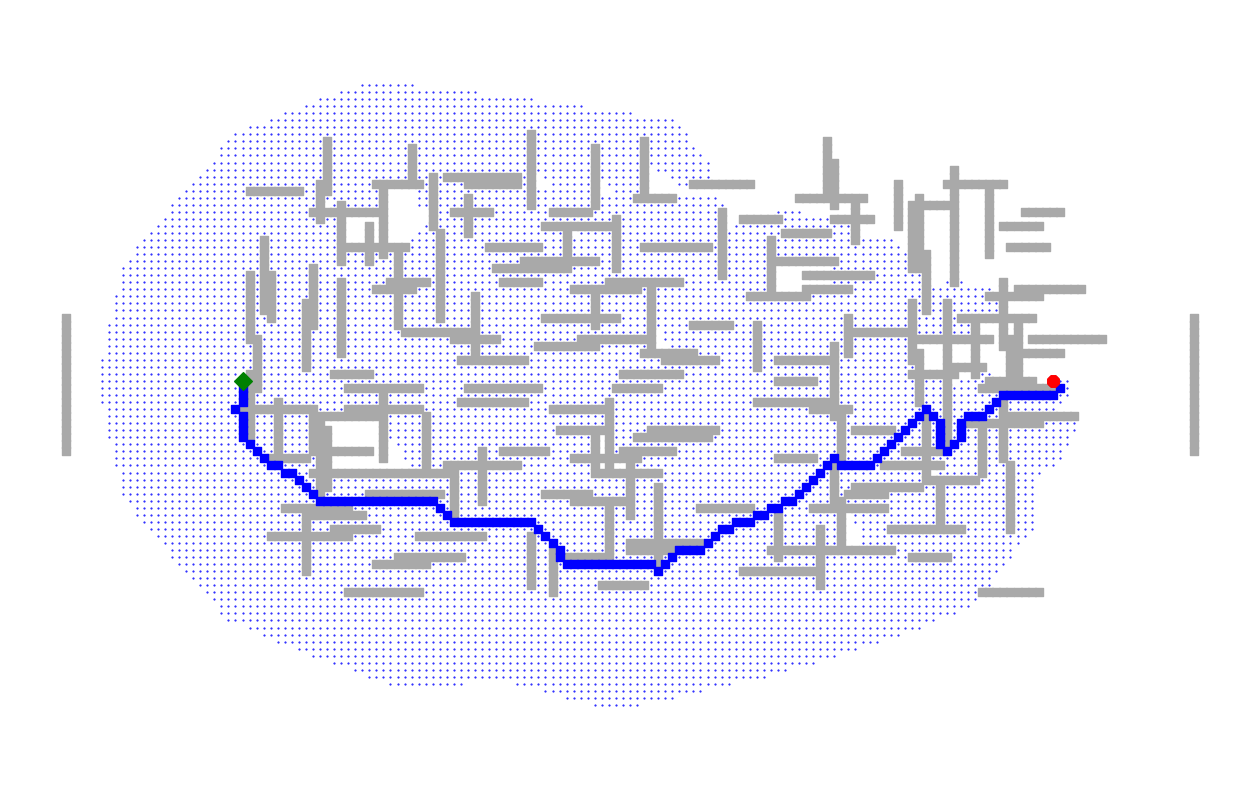

           A* search search: 154.2 path cost, 7,418 states reached


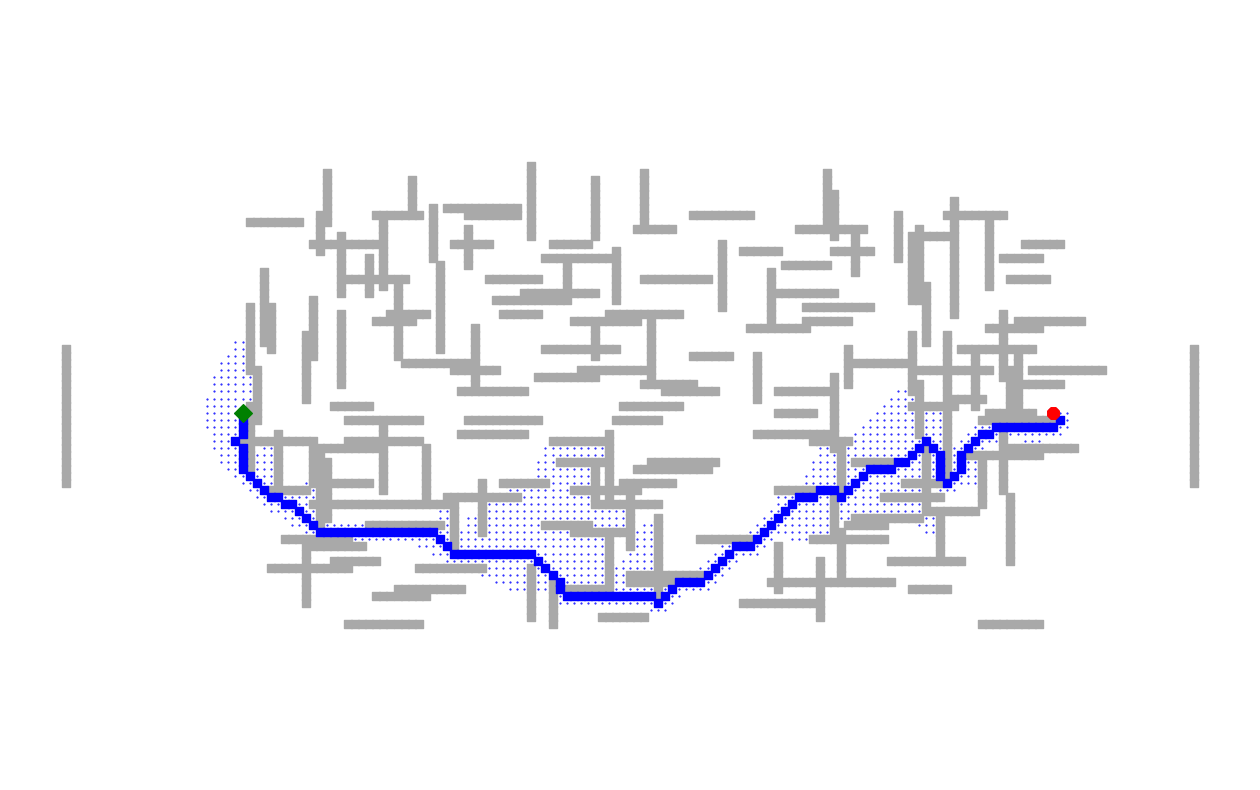

           (b) Weighted (1.4) A* search search: 154.2 path cost, 944 states reached


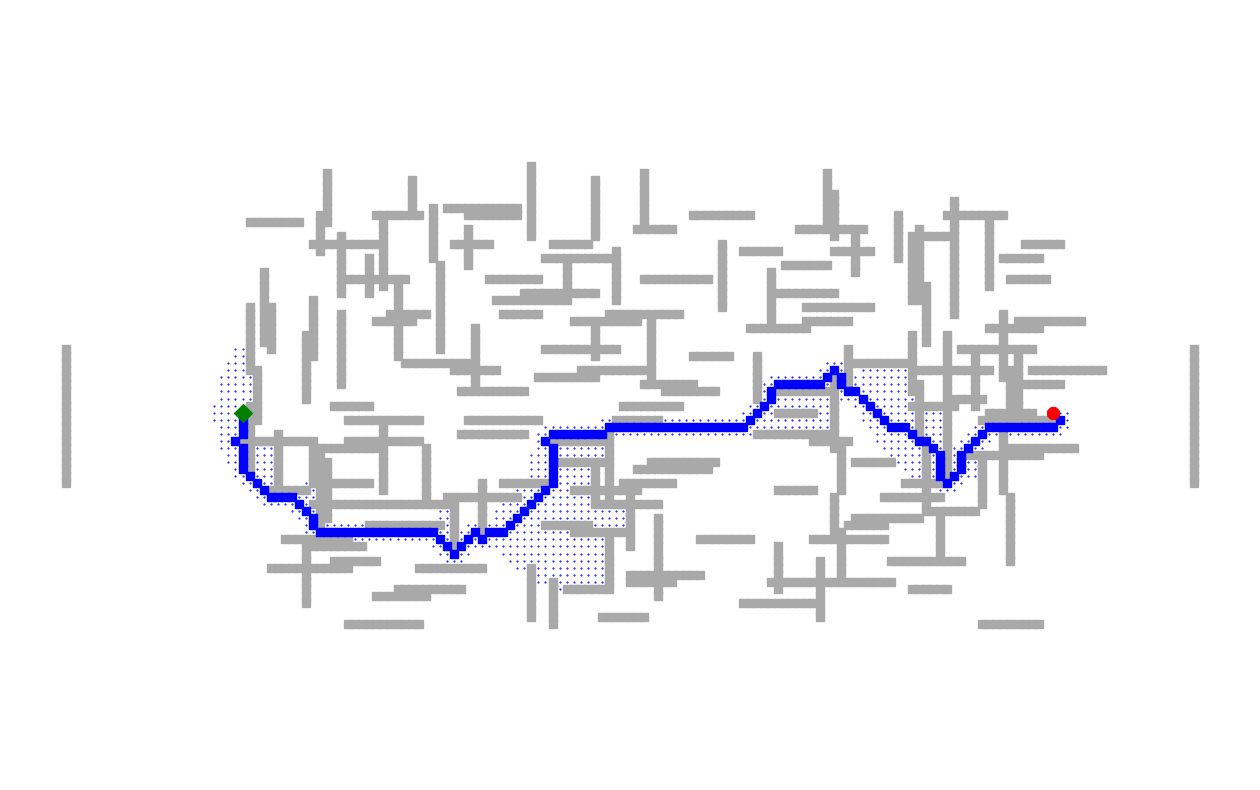

           (b) Weighted (2) A* search search: 162.8 path cost, 782 states reached


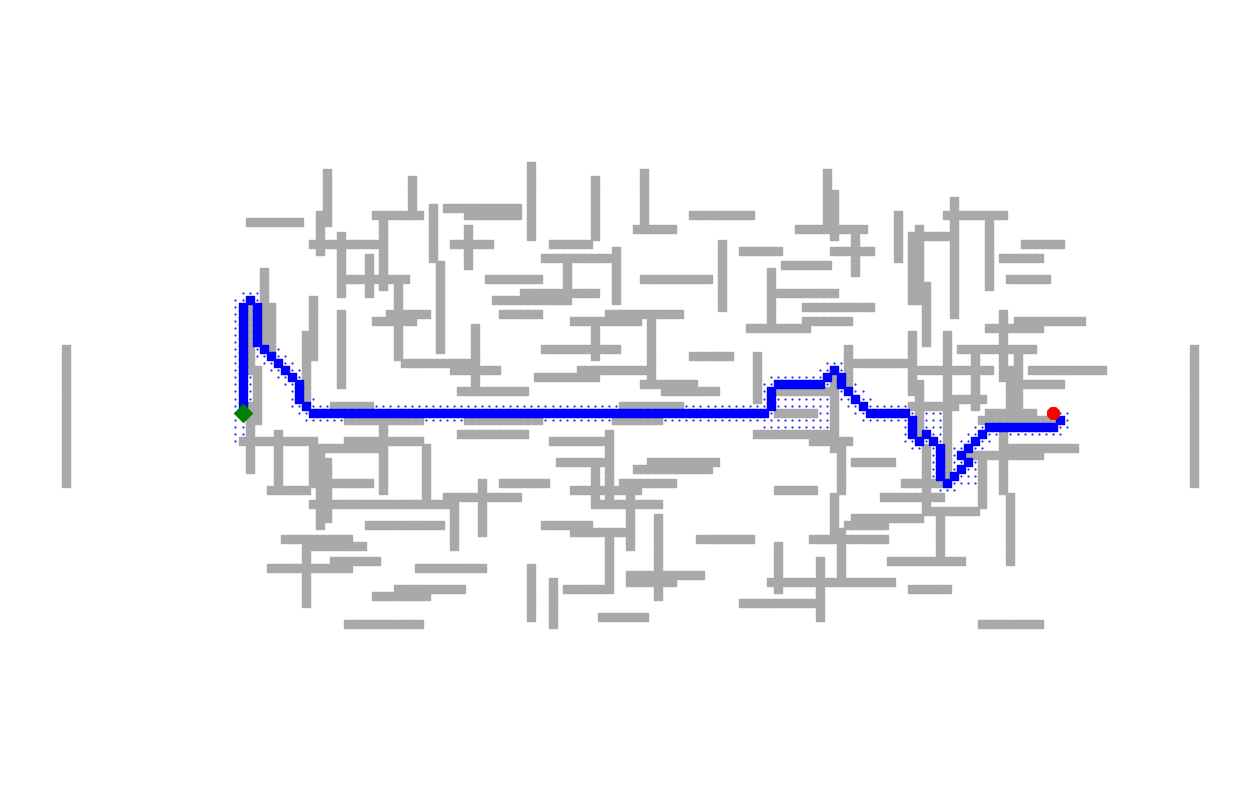

           Greedy best-first search search: 164.5 path cost, 448 states reached


In [43]:
plots(d3)

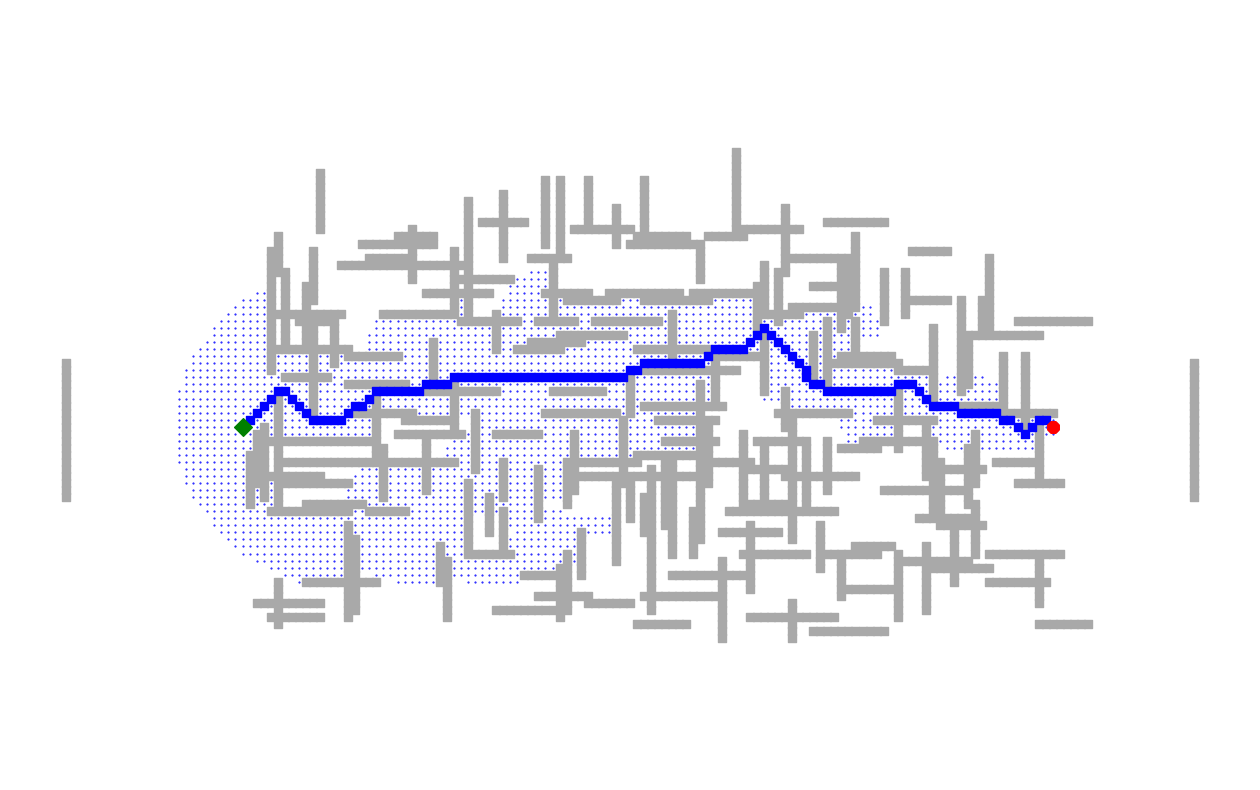

           A* search search: 133.0 path cost, 2,196 states reached


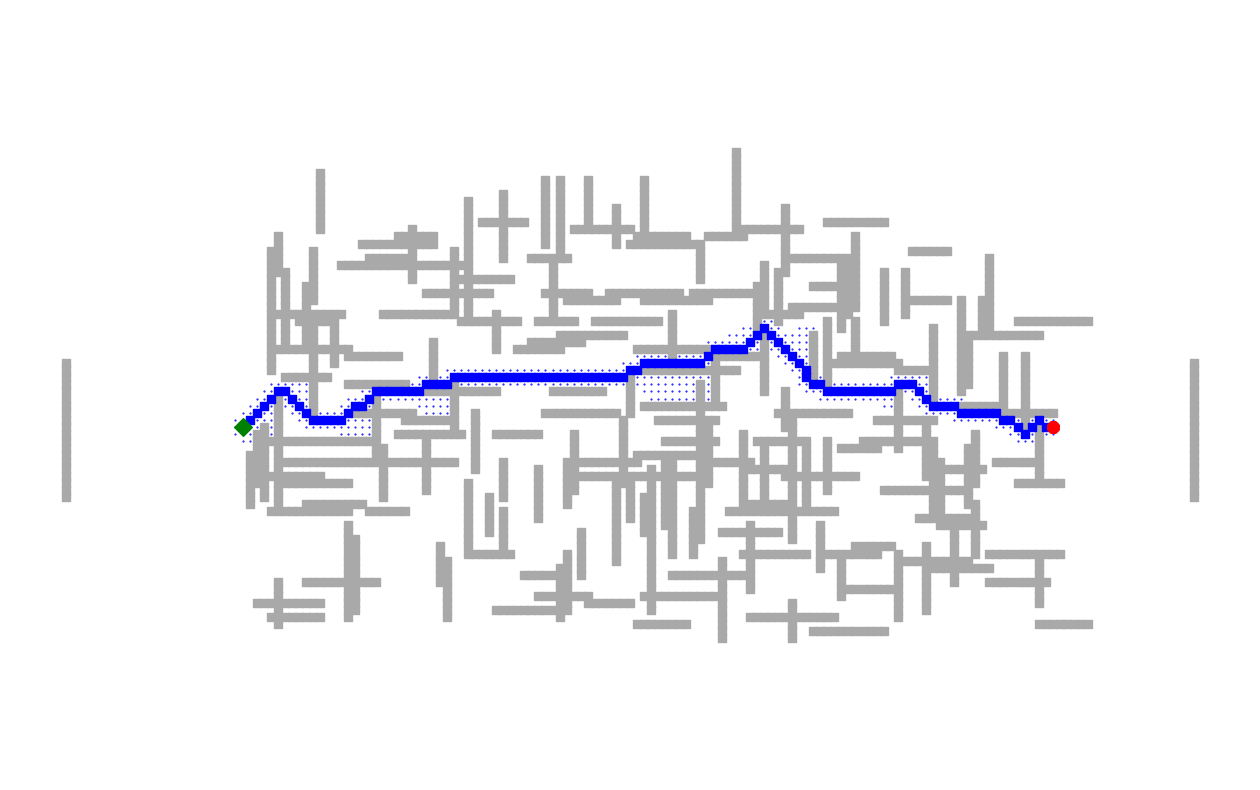

           (b) Weighted (1.4) A* search search: 133.0 path cost, 440 states reached


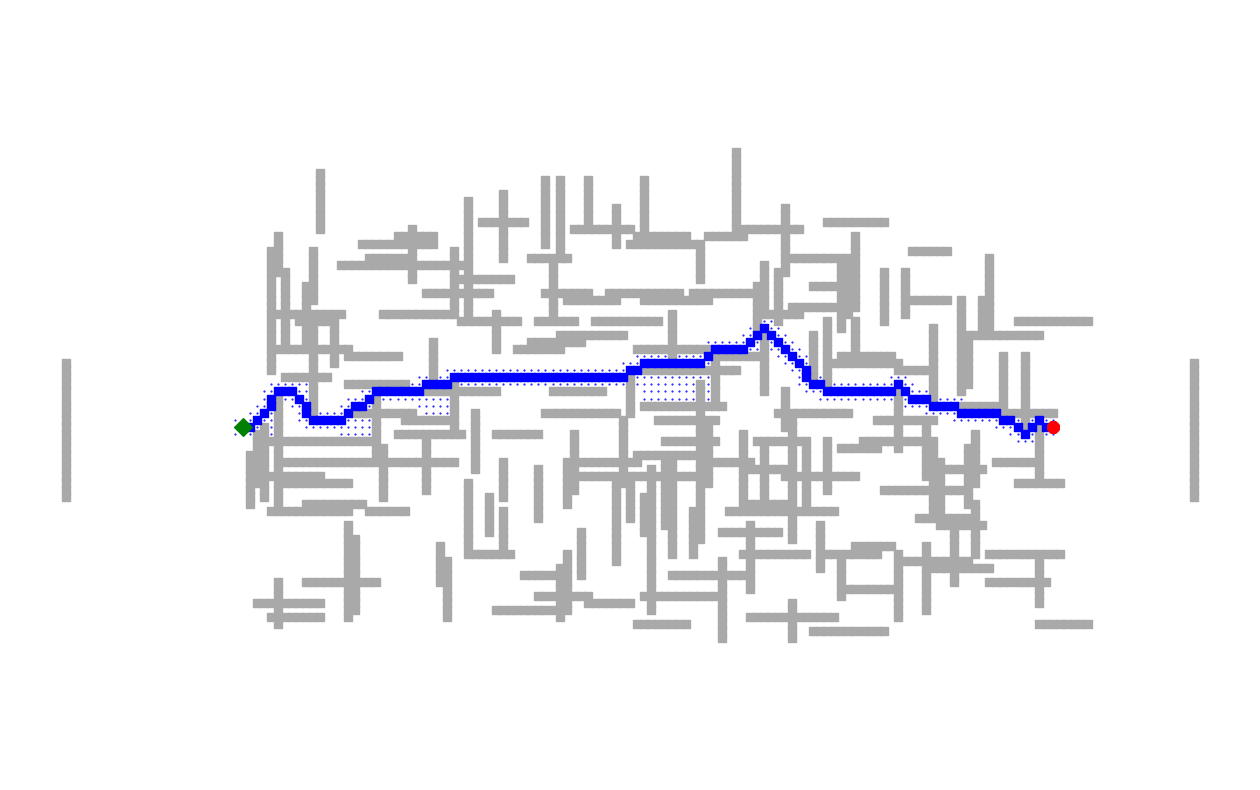

           (b) Weighted (2) A* search search: 134.2 path cost, 418 states reached


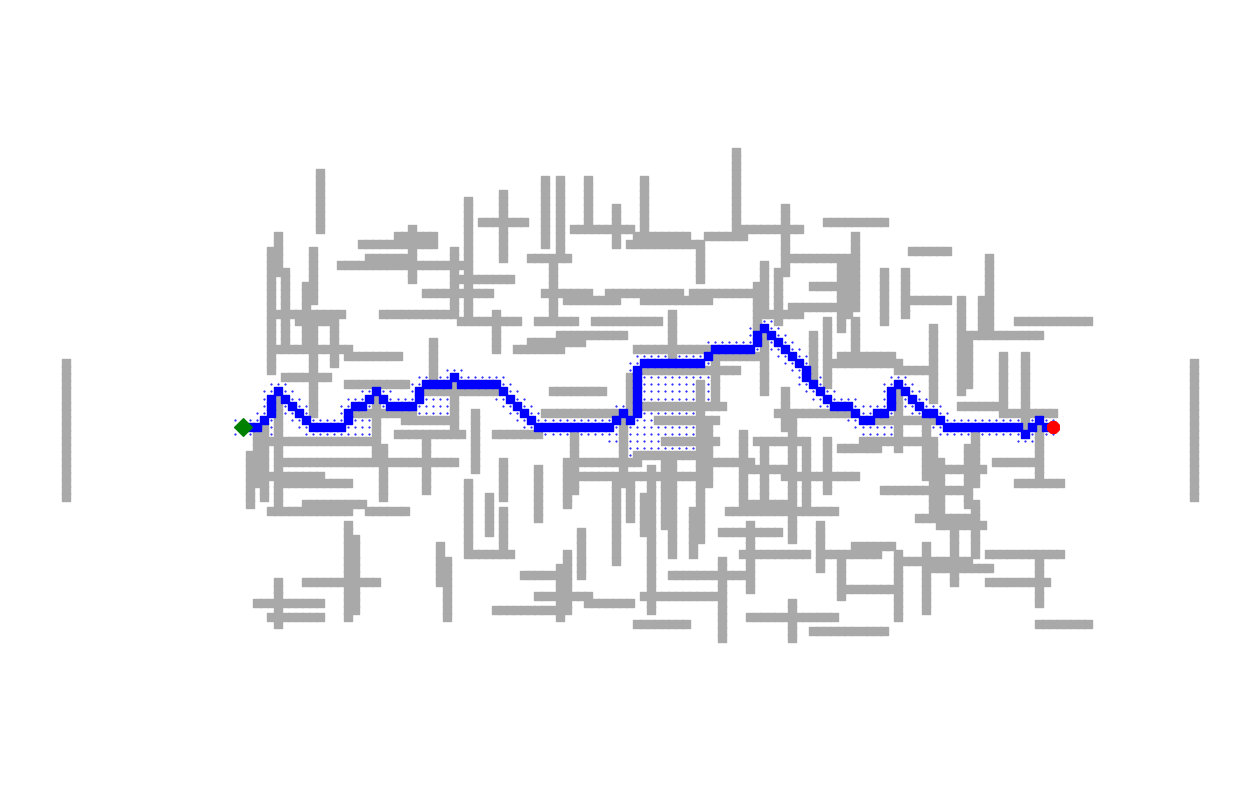

           Greedy best-first search search: 153.0 path cost, 502 states reached


In [44]:
plots(d4)

# The cost of weighted A* search

Now I want to try a much simpler grid problem, `d6`, with only a few obstacles. We see that A* finds the optimal path, skirting below the obstacles. Weighterd A* with a weight of 1.4 finds the same optimal path while exploring only 1/3 the number of states. But weighted A* with weight 2 takes the slightly longer path above the obstacles, because that path allowed it to stay closer to the goal in straight-line distance, which it over-weights. And greedy best-first search has a bad showing, not deviating from its path towards the goal until it is almost inside the cup made by the obstacles.

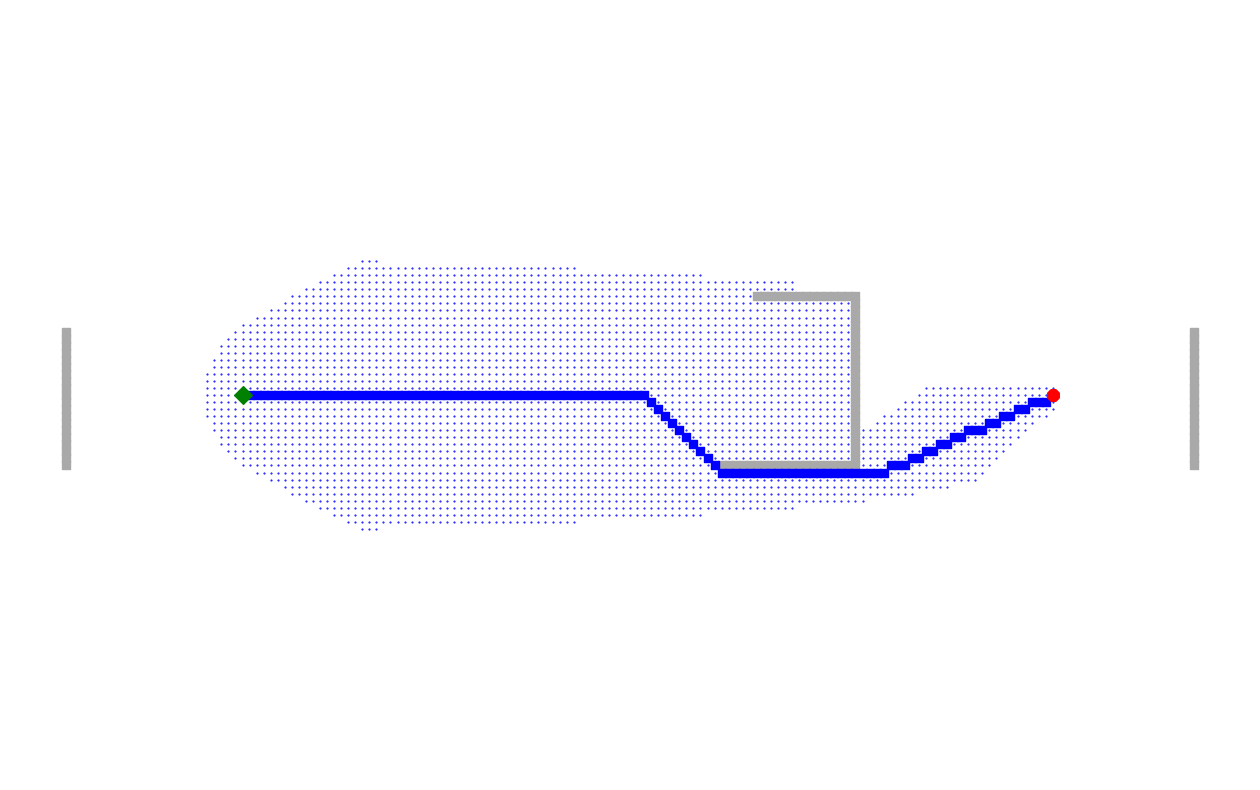

           A* search search: 124.1 path cost, 3,305 states reached


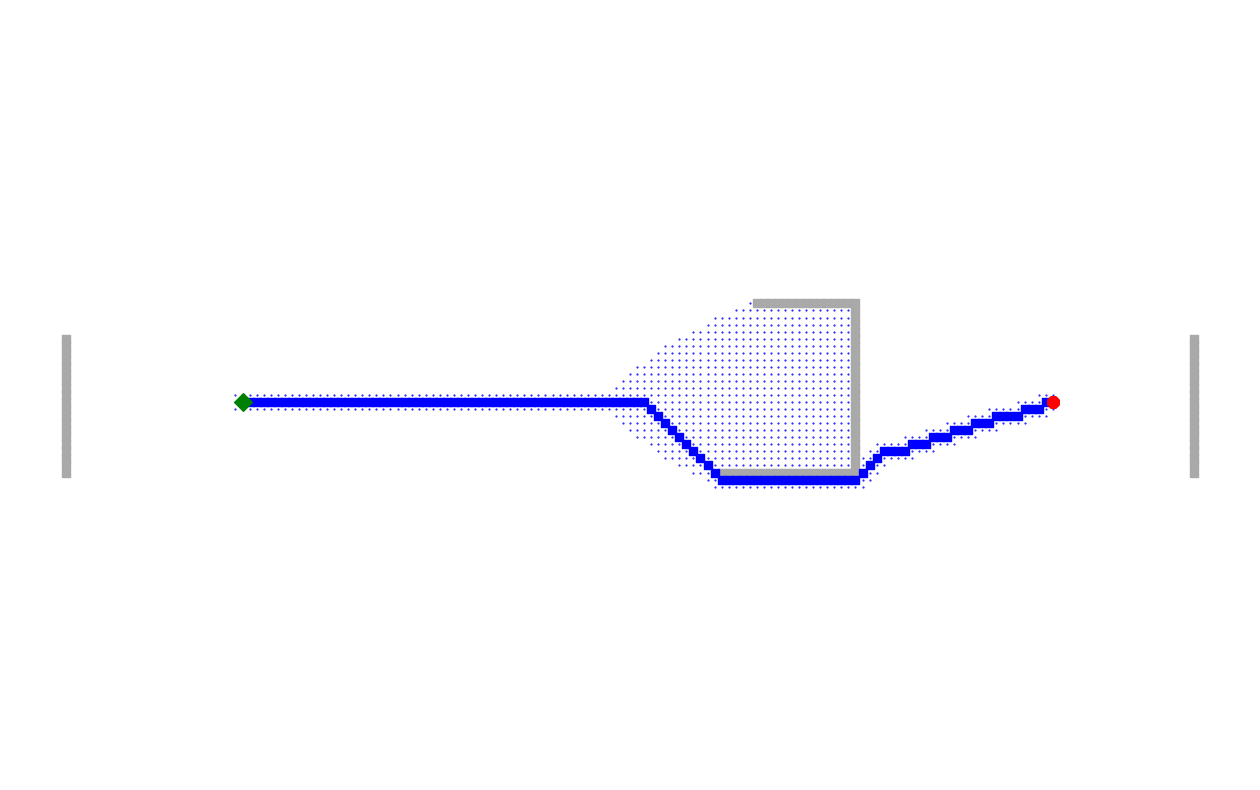

           (b) Weighted (1.4) A* search search: 124.1 path cost, 976 states reached


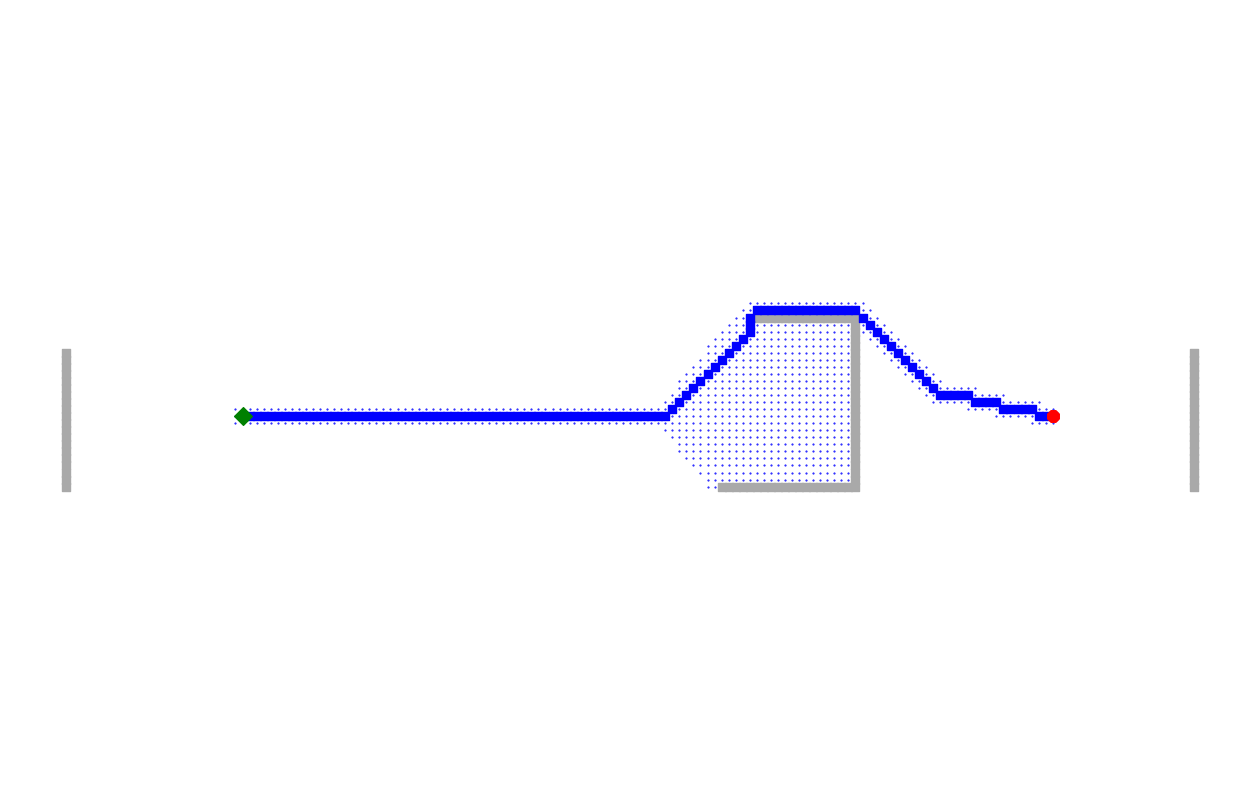

           (b) Weighted (2) A* search search: 128.6 path cost, 879 states reached


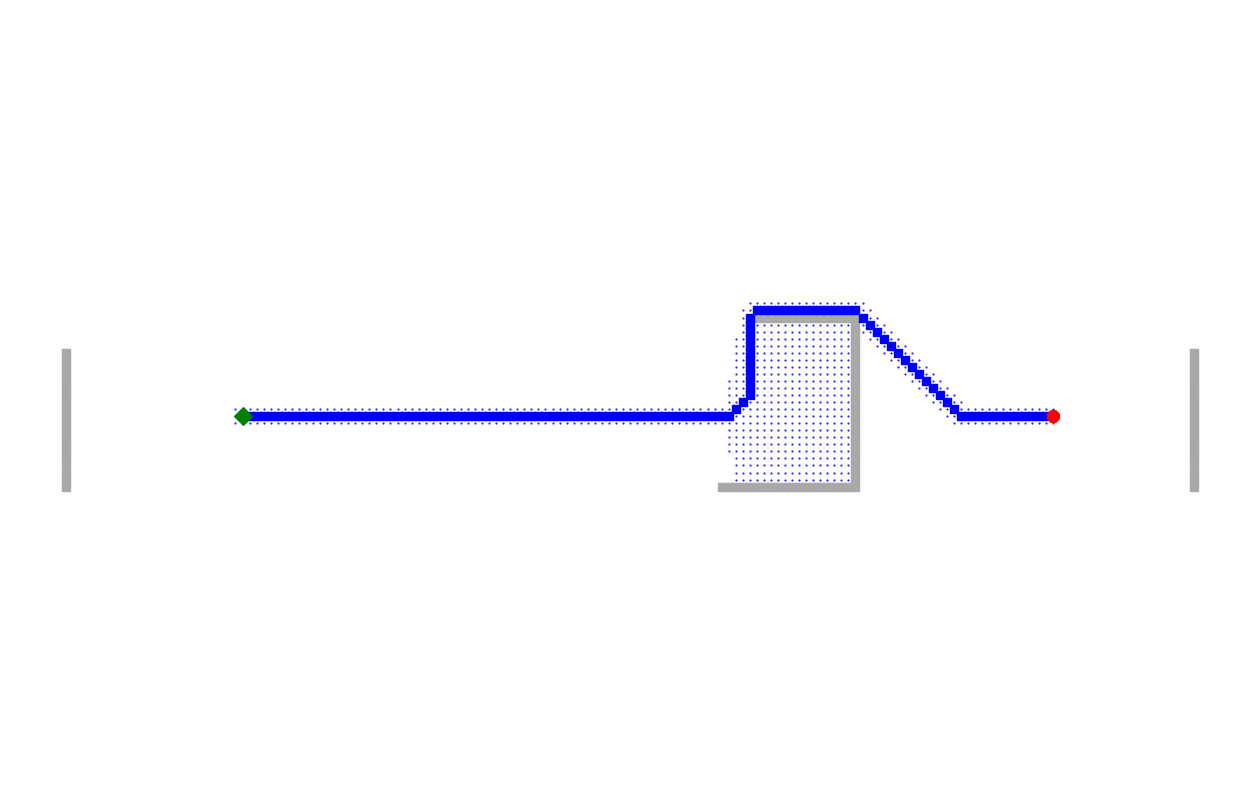

           Greedy best-first search search: 133.9 path cost, 758 states reached


In [45]:
plots(d6)

In the next problem, `d7`, we see a similar story. the optimal path found by A*, and we see that again weighted A* with weight 1.4 does great and with weight 2 ends up erroneously going below the first two barriers, and then makes another mistake by reversing direction back towards the goal and passing above the third barrier. Again, greedy best-first makes bad decisions all around.

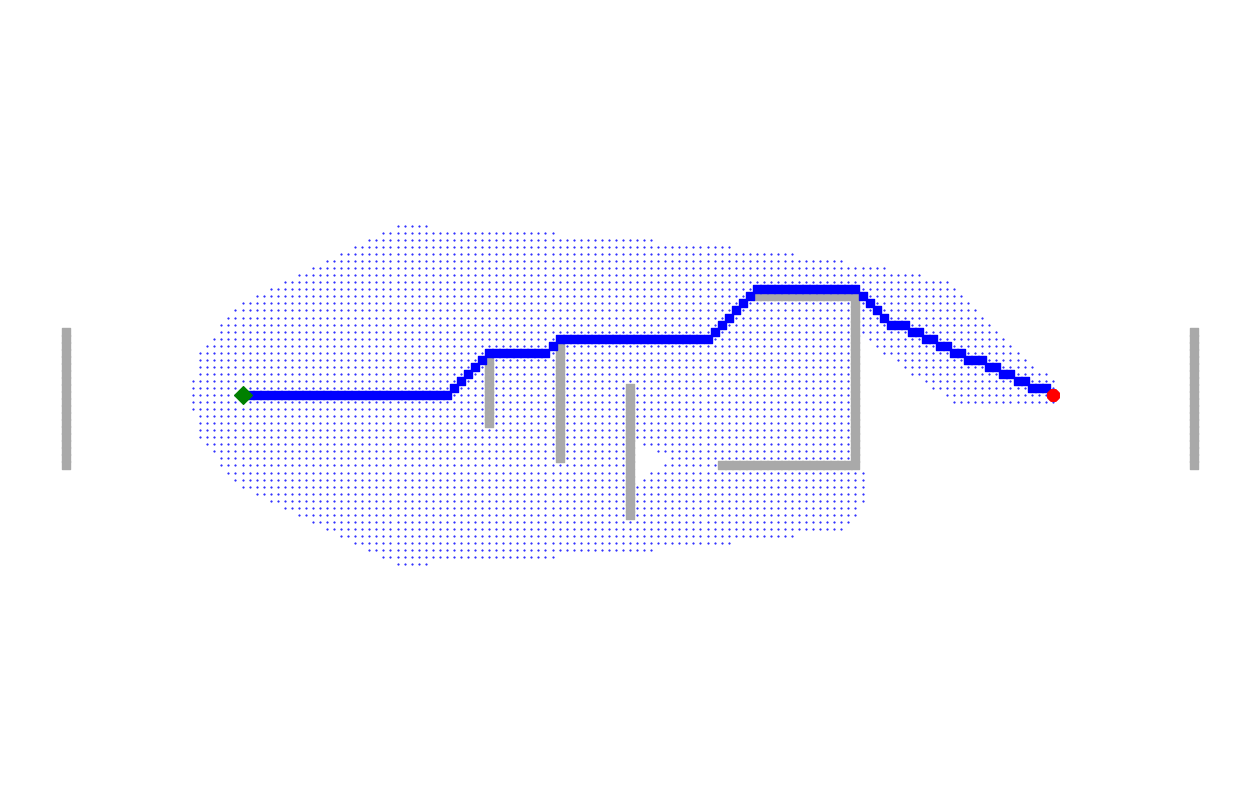

           A* search search: 127.4 path cost, 4,058 states reached


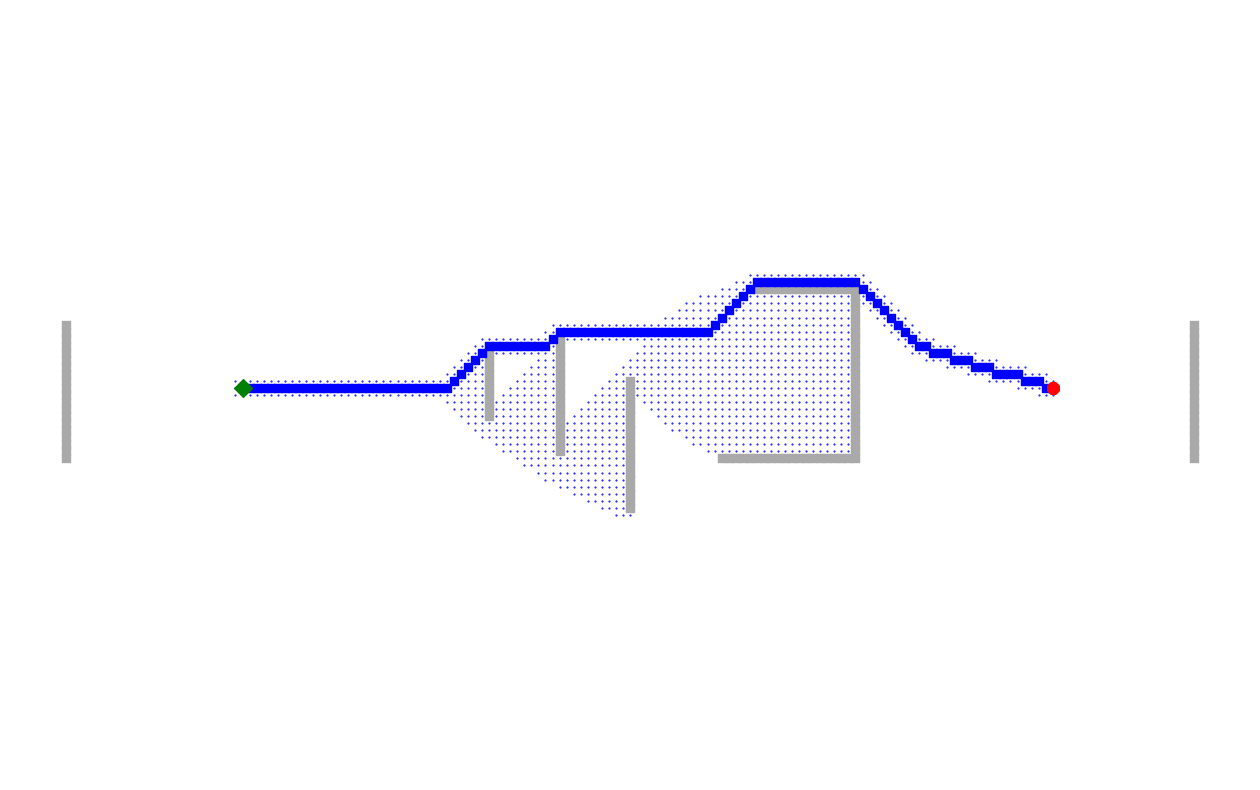

           (b) Weighted (1.4) A* search search: 127.4 path cost, 1,290 states reached


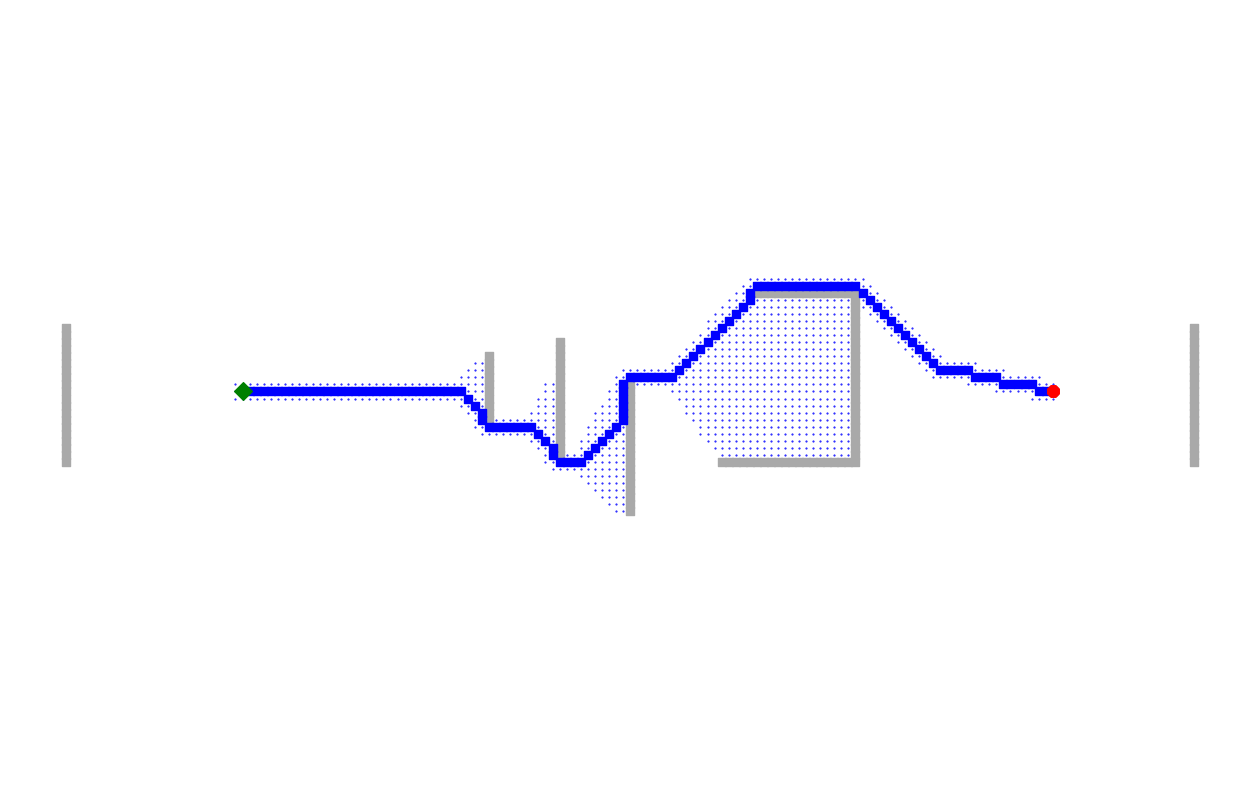

           (b) Weighted (2) A* search search: 140.4 path cost, 980 states reached


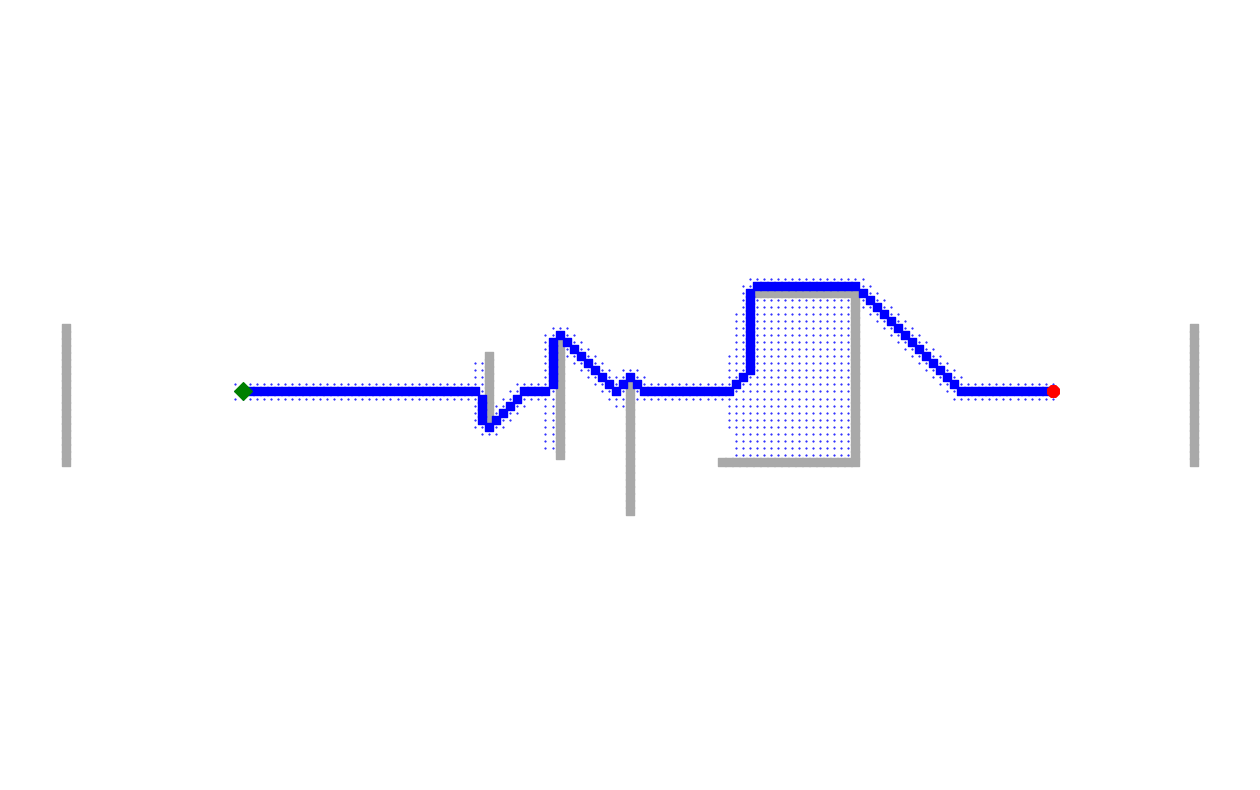

           Greedy best-first search search: 151.6 path cost, 830 states reached


In [46]:
plots(d7)

# Nondeterministic Actions

To handle problems with nondeterministic problems, we'll replace the `result` method with `results`, which returns a collection of possible result states. We'll represent the solution to a problem not with a `Node`, but with a plan that consist of two types of component: sequences of actions, like `['forward', 'suck']`, and condition actions, like
`{5: ['forward', 'suck'], 7: []}`, which says that if we end up in state 5, then do `['forward', 'suck']`, but if we end up in state 7, then do the empty sequence of actions.

In [47]:
def and_or_search(problem):
    "Find a plan for a problem that has nondterministic actions."
    return or_search(problem, problem.initial, [])
    
def or_search(problem, state, path):
    "Find a sequence of actions to reach goal from state, without repeating states on path."
    if problem.is_goal(state): return []
    if state in path: return failure # check for loops
    for action in problem.actions(state):
        plan = and_search(problem, problem.results(state, action), [state] + path)
        if plan != failure:
            return [action] + plan
    return failure

def and_search(problem, states, path):
    "Plan for each of the possible states we might end up in."
    if len(states) == 1: 
        return or_search(problem, next(iter(states)), path)
    plan = {}
    for s in states:
        plan[s] = or_search(problem, s, path)
        if plan[s] == failure: return failure
    return [plan]

In [48]:
class MultiGoalProblem(Problem):
    """A version of `Problem` with a colllection of `goals` instead of one `goal`."""
    
    def __init__(self, initial=None, goals=(), **kwds): 
        self.__dict__.update(initial=initial, goals=goals, **kwds)
        
    def is_goal(self, state): return state in self.goals
    
class ErraticVacuum(MultiGoalProblem):
    """In this 2-location vacuum problem, the suck action in a dirty square will either clean up that square,
    or clean up both squares. A suck action in a clean square will either do nothing, or
    will deposit dirt in that square. Forward and backward actions are deterministic."""
    
    def actions(self, state): 
        return ['suck', 'forward', 'backward']
    
    def results(self, state, action): return self.table[action][state]
    
    table = {'suck':{1:{5,7}, 2:{4,8}, 3:{7}, 4:{2,4}, 5:{1,5}, 6:{8}, 7:{3,7}, 8:{6,8}},
             'forward': {1:{2}, 2:{2}, 3:{4}, 4:{4}, 5:{6}, 6:{6}, 7:{8}, 8:{8}},
             'backward': {1:{1}, 2:{1}, 3:{3}, 4:{3}, 5:{5}, 6:{5}, 7:{7}, 8:{7}}}

Let's find a plan to get from state 1 to the goal of no dirt (states 7 or 8):

In [49]:
and_or_search(ErraticVacuum(1, {7, 8}))

['suck', {5: ['forward', 'suck'], 7: []}]

This plan says "First suck, and if we end up in state 5, go forward and suck again; if we end up in state 7, do nothing because that is a goal."

Here are the plans to get to a goal state starting from any one of the 8 states:

In [50]:
{s: and_or_search(ErraticVacuum(s, {7,8})) 
 for s in range(1, 9)}

{1: ['suck', {5: ['forward', 'suck'], 7: []}],
 2: ['suck', {8: [], 4: ['backward', 'suck']}],
 3: ['suck'],
 4: ['backward', 'suck'],
 5: ['forward', 'suck'],
 6: ['suck'],
 7: [],
 8: []}

In [51]:
graph = {
    'P': ['Q', 'R', 'S'],   # Q is leftmost child of P
    'Q': ['P', 'R'],         # P is visited before, R is next
    'R': ['P', 'Q', 'T'],    # anti-clockwise: P, Q, T
    'S': ['P', 'T'],         # anti-clockwise: P, T
    'T': ['R', 'S']          # anti-clockwise: R, S
}

def dfs_with_steps(graph, start):
    """
    Perform DFS traversal with step-by-step output.
    Visits children in the order they appear in the adjacency list.
    """
    visited = set()
    stack = [start]
    step = 0
    traversal_order = []
    
    print(f"Starting DFS from node '{start}'")
    print(f"{'='*50}")
    
    while stack:
        step += 1
        node = stack.pop()
        
        if node not in visited:
            visited.add(node)
            traversal_order.append(node)
            
            print(f"Step {step}: Visit node '{node}'")
            print(f"         Visited so far: {traversal_order}")
            
            # Get unvisited neighbors in reverse order (since stack is LIFO)
            # This ensures leftmost child is visited first
            neighbors = [n for n in graph[node] if n not in visited]
            
            if neighbors:
                print(f"         Unvisited neighbors: {neighbors}")
                # Push in reverse order so leftmost is popped first
                for neighbor in reversed(neighbors):
                    stack.append(neighbor)
                print(f"         Stack after push: {list(stack)}")
            else:
                print(f"         No unvisited neighbors")
                print(f"         Stack: {list(stack)}")
            print()
    
    print(f"{'='*50}")
    print(f"DFS Traversal Complete!")
    print(f"Final traversal order: {' -> '.join(traversal_order)}")
    return traversal_order

# Run DFS starting from P
dfs_result = dfs_with_steps(graph, 'P')

Starting DFS from node 'P'
Step 1: Visit node 'P'
         Visited so far: ['P']
         Unvisited neighbors: ['Q', 'R', 'S']
         Stack after push: ['S', 'R', 'Q']

Step 2: Visit node 'Q'
         Visited so far: ['P', 'Q']
         Unvisited neighbors: ['R']
         Stack after push: ['S', 'R', 'R']

Step 3: Visit node 'R'
         Visited so far: ['P', 'Q', 'R']
         Unvisited neighbors: ['T']
         Stack after push: ['S', 'R', 'T']

Step 4: Visit node 'T'
         Visited so far: ['P', 'Q', 'R', 'T']
         Unvisited neighbors: ['S']
         Stack after push: ['S', 'R', 'S']

Step 5: Visit node 'S'
         Visited so far: ['P', 'Q', 'R', 'T', 'S']
         No unvisited neighbors
         Stack: ['S', 'R']

DFS Traversal Complete!
Final traversal order: P -> Q -> R -> T -> S


In [52]:
class TwoFriendMeeting(Problem):
    """
    Two friends want to meet in the same city on a map.
    On each turn, BOTH friends must move to a neighboring city.
    Goal: minimize the number of turns to meet.
    
    State: (city1, city2) - the current locations of both friends
    Action: (move1, move2) - the cities each friend moves to
    Goal: city1 == city2 (both friends in the same city)
    """
    
    def __init__(self, initial, map):
        """
        initial: tuple (start_city1, start_city2) - starting cities for both friends
        map: the Map object (e.g., romania)
        """
        self.initial = initial
        self.map = map
        self.goal = None  # Goal is when both are in same city (checked by is_goal)
    
    def actions(self, state):
        """
        Return all possible joint actions (move1, move2).
        Each friend must move to a neighboring city.
        """
        city1, city2 = state
        neighbors1 = self.map.neighbors[city1]
        neighbors2 = self.map.neighbors[city2]
        
        # All combinations of moves for both friends
        # Each friend MUST move to a neighbor (cannot stay)
        actions = []
        for n1 in neighbors1:
            for n2 in neighbors2:
                actions.append((n1, n2))
        return actions
    
    def result(self, state, action):
        """
        Apply the action: both friends move to their respective destinations.
        """
        move1, move2 = action
        return (move1, move2)
    
    def is_goal(self, state):
        """
        Goal is reached when both friends are in the same city.
        """
        city1, city2 = state
        return city1 == city2
    
    def action_cost(self, s, action, s1):
        """
        Each turn costs 1 (we want to minimize turns, not distance).
        """
        return 1


# Create the two friend meeting problem: Arad ('A') and Bucharest ('B')
two_friends = TwoFriendMeeting(initial=('A', 'B'), map=romania)

# Run Breadth-First Search (optimal for minimizing turns since all actions cost 1)
solution = breadth_first_search(two_friends)

# Extract the solution path
solution_path = path_states(solution)
num_turns = len(solution_path) - 1  # Subtract 1 because initial state is not a turn

# The meeting city is where both friends end up (same city in goal state)
if solution_path:
    meeting_city = solution_path[-1][0]  # Both cities are the same at goal
    
    # Map single letters to full city names for clarity
    city_names = {
        'A': 'Arad', 'B': 'Bucharest', 'C': 'Craiova', 'D': 'Drobeta',
        'E': 'Eforie', 'F': 'Fagaras', 'G': 'Giurgiu', 'H': 'Hirsova',
        'I': 'Iasi', 'L': 'Lugoj', 'M': 'Mehadia', 'N': 'Neamt',
        'O': 'Oradea', 'P': 'Pitesti', 'R': 'Rimnicu Vilcea', 'S': 'Sibiu',
        'T': 'Timisoara', 'U': 'Urziceni', 'V': 'Vaslui', 'Z': 'Zerind'
    }
    
    print("=" * 60)
    print("TWO FRIEND MEETING PROBLEM - SOLUTION")
    print("=" * 60)
    print(f"\nInitial State: Friend 1 in {city_names.get('A', 'A')}, Friend 2 in {city_names.get('B', 'B')}")
    print(f"\nPath of states (Friend1_city, Friend2_city):")
    
    for i, state in enumerate(solution_path):
        c1, c2 = state
        if i == 0:
            print(f"  Start: ({city_names.get(c1, c1)}, {city_names.get(c2, c2)})")
        else:
            print(f"  Turn {i}: ({city_names.get(c1, c1)}, {city_names.get(c2, c2)})")
    
    print(f"\n{'=' * 60}")
    print(f"RESULT: The two friends meet in {city_names.get(meeting_city, meeting_city)}")
    print(f"NUMBER OF TURNS: {num_turns}")
    print("=" * 60)
else:
    print("No solution found!")

TWO FRIEND MEETING PROBLEM - SOLUTION

Initial State: Friend 1 in Arad, Friend 2 in Bucharest

Path of states (Friend1_city, Friend2_city):
  Start: (Arad, Bucharest)
  Turn 1: (Sibiu, Pitesti)
  Turn 2: (Rimnicu Vilcea, Rimnicu Vilcea)

RESULT: The two friends meet in Rimnicu Vilcea
NUMBER OF TURNS: 2


# 8-Puzzle: Comparing A* and Greedy Best-First Search with Two Heuristics

We solve the 8-puzzle using **4 combinations** of algorithms and heuristics:

| # | Algorithm | Heuristic | f(n) |
|---|-----------|-----------|------|
| 1 | A* Search | Misplaced Tiles (h1) | f = g + h1 |
| 2 | A* Search | Manhattan Distance (h2) | f = g + h2 |
| 3 | Greedy Best-First Search | Misplaced Tiles (h1) | f = h1 |
| 4 | Greedy Best-First Search | Manhattan Distance (h2) | f = h2 |

We use the `CountCalls` wrapper and `report` function defined earlier to collect statistics.


In [53]:
# Define the 4 algorithm+heuristic combinations as named functions

def astar_h1(problem):
    """A* search with misplaced tiles heuristic."""
    return astar_search(problem, h=problem.h1)

def astar_h2(problem):
    """A* search with Manhattan heuristic."""
    return astar_search(problem, h=problem.h2)

def greedy_h1(problem):
    """Greedy best-first search with misplaced tiles heuristic."""
    return greedy_bfs(problem, h=problem.h1)

def greedy_h2(problem):
    """Greedy best-first search with Manhattan heuristic."""
    return greedy_bfs(problem, h=problem.h2)

In [54]:
# Run report on all 5 eight-puzzle instances with the 4 algorithm/heuristic combos
print("=" * 90)
print("  8-PUZZLE: 2 Algorithms x 2 Heuristics  — Detailed Statistics")
print("=" * 90)

searchers = [astar_h1, astar_h2, greedy_h1, greedy_h2]
puzzles   = [e1, e2, e3, e4, e5]

report(searchers, puzzles, verbose=True)

  8-PUZZLE: 2 Algorithms x 2 Heuristics  — Detailed Statistics
astar_h1:
       17 nodes |        7 goal |    5 cost |      11 actions | EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8),
   23,407 nodes |    8,726 goal |   22 cost |   8,747 actions | EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0),
   38,632 nodes |   14,433 goal |   23 cost |  14,455 actions | EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6),
  124,324 nodes |   46,553 goal |   26 cost |  46,578 actions | EightPuzzle((7, 2, 4, 5, 0, 6, 8, 3, 1),
  156,111 nodes |   58,475 goal |   27 cost |  58,501 actions | EightPuzzle((8, 6, 7, 2, 5, 4, 3, 0, 1),
  342,491 nodes |  128,194 goal |  103 cost | 128,292 actions | TOTAL

astar_h2:
       15 nodes |        6 goal |    5 cost |      10 actions | EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8),
    3,614 nodes |    1,349 goal |   22 cost |   1,370 actions | EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0),
    5,373 nodes |    2,010 goal |   23 cost |   2,032 actions | EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6),
   10,

In [55]:
# Run report on all 5 eight-puzzle instances with the 4 algorithm/heuristic combos
print("=" * 90)
print("  8-PUZZLE: 2 Algorithms x 2 Heuristics  — Detailed Statistics")
print("=" * 90)

searchers = [astar_h1, astar_h2, greedy_h1, greedy_h2]
puzzles   = [e1, e2, e3, e4, e5]

report(searchers, puzzles, verbose=True)

  8-PUZZLE: 2 Algorithms x 2 Heuristics  — Detailed Statistics
astar_h1:
       17 nodes |        7 goal |    5 cost |      11 actions | EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8),
   23,407 nodes |    8,726 goal |   22 cost |   8,747 actions | EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0),
   38,632 nodes |   14,433 goal |   23 cost |  14,455 actions | EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6),
  124,324 nodes |   46,553 goal |   26 cost |  46,578 actions | EightPuzzle((7, 2, 4, 5, 0, 6, 8, 3, 1),
  156,111 nodes |   58,475 goal |   27 cost |  58,501 actions | EightPuzzle((8, 6, 7, 2, 5, 4, 3, 0, 1),
  342,491 nodes |  128,194 goal |  103 cost | 128,292 actions | TOTAL

astar_h2:
       15 nodes |        6 goal |    5 cost |      10 actions | EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8),
    3,614 nodes |    1,349 goal |   22 cost |   1,370 actions | EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0),
    5,373 nodes |    2,010 goal |   23 cost |   2,032 actions | EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6),
   10,

NameError: name 'rows' is not defined

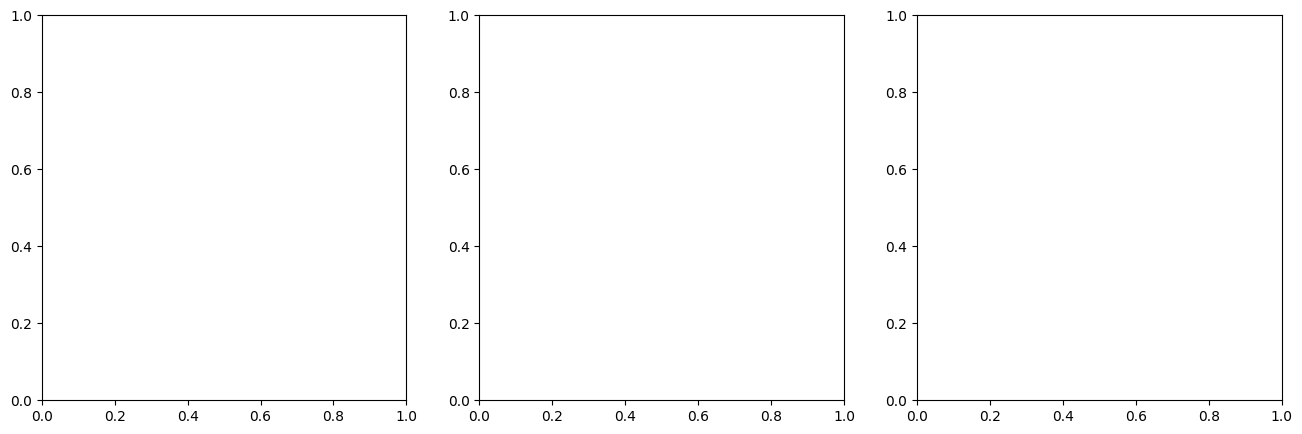

In [56]:
# Bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
names  = [f"{r['Algorithm']}\n{r['Heuristic']}" for r in rows]
colors = ['#e74c3c', '#2ecc71', '#3498db', '#f39c12']

# Nodes expanded
axes[0].bar(names, [r['Nodes Expanded'] for r in rows], color=colors)
axes[0].set_title('Total Nodes Expanded (lower = better)')
axes[0].set_ylabel('Nodes')
for i, v in enumerate([r['Nodes Expanded'] for r in rows]):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Total path cost
axes[1].bar(names, [r['Total Cost'] for r in rows], color=colors)
axes[1].set_title('Total Path Cost (lower = better)')
axes[1].set_ylabel('Cost')
for i, v in enumerate([r['Total Cost'] for r in rows]):
    axes[1].text(i, v, str(v), ha='center', va='bottom', fontsize=9, fontweight='bold')

# Wall-clock time
axes[2].bar(names, [r['Time (s)'] for r in rows], color=colors)
axes[2].set_title('Wall-Clock Time (lower = better)')
axes[2].set_ylabel('Seconds')
for i, v in enumerate([r['Time (s)'] for r in rows]):
    axes[2].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# 8-Puzzle Comparison: A* vs Greedy BFS with Two Heuristics

This cell compares two search algorithms with two different heuristics on five 8-puzzle instances:

| Algorithm | h1 Heuristic | h2 Heuristic |
|-----------|--------------|--------------|
| **A* Search** | Misplaced Tiles | Manhattan Distance |
| **Greedy Best-First** | Misplaced Tiles | Manhattan Distance |

**Key observations:**
- A* guarantees optimal solutions (cost = 103) but explores many more nodes
- Greedy BFS is much faster but finds suboptimal solutions
- Better heuristics (h2) reduce nodes explored by ~10x for A*

SyntaxError: invalid character '–' (U+2013) (899998353.py, line 3)


8-Puzzle: A* vs Greedy BFS × Misplaced Tiles (h1) vs Manhattan (h2)

Algorithm               Nodes  Goal Tests   Cost Time (s)
----------------------------------------------------------
A* + h1               342,491     128,194    103   1.9905
A* + h2                31,503      11,868    103   0.2102
Greedy BFS + h1         6,830       2,505    185   0.0235
Greedy BFS + h2         4,494       1,634    205   0.0225


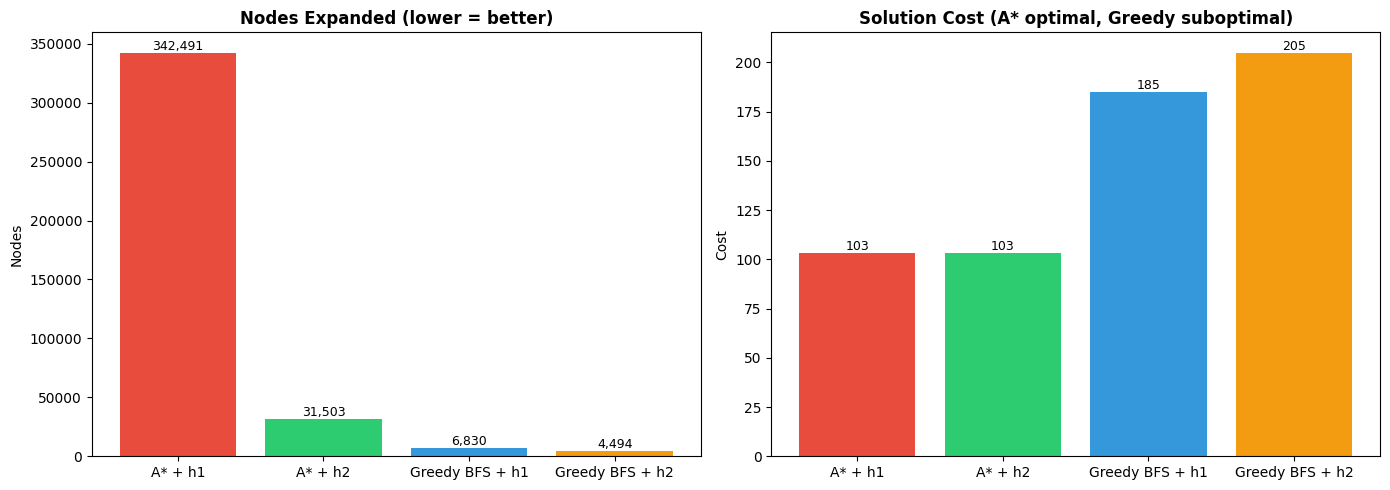

In [69]:
# Define the four algorithm/heuristic combinations
def astar_h1(problem): return astar_search(problem, h=problem.h1)
def astar_h2(problem): return astar_search(problem, h=problem.h2)
def greedy_bfs_h1(problem): return greedy_bfs(problem, h=problem.h1)
def greedy_bfs_h2(problem): return greedy_bfs(problem, h=problem.h2)

# Test all four combinations on the five 8-puzzle instances
puzzles = [e1, e2, e3, e4, e5]
algorithms = [
    (astar_h1, "A* + h1"),
    (astar_h2, "A* + h2"),
    (greedy_bfs_h1, "Greedy BFS + h1"),
    (greedy_bfs_h2, "Greedy BFS + h2"),
]

import time, matplotlib.pyplot as plt

# Collect statistics
results = []
for searcher, label in algorithms:
    nodes, goal_tests, total_cost, total_actions = 0, 0, 0, 0
    t0 = time.perf_counter()
    for puzzle in puzzles:
        prob = CountCalls(puzzle)
        soln = searcher(prob)
        nodes += prob._counts['result']
        goal_tests += prob._counts['is_goal']
        total_cost += soln.path_cost
        total_actions += len(soln)
    elapsed = time.perf_counter() - t0
    results.append({'Label': label, 'Nodes': nodes, 'Tests': goal_tests, 
                    'Cost': total_cost, 'Time': elapsed})

# Print summary
print("\n8-Puzzle: A* vs Greedy BFS × Misplaced Tiles (h1) vs Manhattan (h2)\n")
print(f"{'Algorithm':<18} {'Nodes':>10} {'Goal Tests':>11} {'Cost':>6} {'Time (s)':>8}")
print("-" * 58)
for r in results:
    print(f"{r['Label']:<18} {r['Nodes']:>10,} {r['Tests']:>11,} {r['Cost']:>6.0f} {r['Time']:>8.4f}")

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
labels = [r['Label'] for r in results]
colors = ['#e74c3c', '#2ecc71', '#3498db', '#f39c12']

axes[0].bar(labels, [r['Nodes'] for r in results], color=colors)
axes[0].set_title('Nodes Expanded (lower = better)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Nodes')
for i, v in enumerate([r['Nodes'] for r in results]):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=9)

axes[1].bar(labels, [r['Cost'] for r in results], color=colors)
axes[1].set_title('Solution Cost (A* optimal, Greedy suboptimal)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cost')
for i, v in enumerate([r['Cost'] for r in results]):
    axes[1].text(i, v, f'{v:.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 4-Directional Grid Problem: UCS vs A*

**Problem:** Solve a grid problem with no obstacles, starting from the origin (0,0) with the goal 5 up and 6 right at (6,5).
- **Movement:** 4 directions only (up, down, left, right) — modified from the 8-direction `GridProblem` in the notebook
- **Heuristic:** Manhattan distance `|x1-x2| + |y1-y2|` — replaces the straight-line distance used in the reference
- **Comparison:** Uniform Cost Search vs A* Search

In [83]:
class GridProblem4Dir(Problem):
    """Grid problem with 4-directional movement (up/down/left/right) and Manhattan distance heuristic.
    Modified from GridProblem which uses 8 directions and straight-line distance."""
    
    def __init__(self, initial=(0, 0), goal=(6, 5), obstacles=(), **kwds):
        Problem.__init__(self, initial=initial, goal=goal, 
                         obstacles=set(obstacles) - {initial, goal}, **kwds)
    
    # 4 directions only: right, left, up (+y), down (-y)
    directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
    
    def action_cost(self, s, action, s1): return 1  # uniform cost per step
    
    def h(self, node):
        """Manhattan distance heuristic (replaces straight-line distance from GridProblem)."""
        return abs(node.state[0] - self.goal[0]) + abs(node.state[1] - self.goal[1])
    
    def result(self, state, action): 
        return action if action not in self.obstacles else state
    
    def actions(self, state):
        x, y = state
        return {(x + dx, y + dy) for (dx, dy) in self.directions} - self.obstacles

# Create the problem: start at origin (0,0), goal 5 up and 6 right at (6,5), no obstacles
grid = GridProblem4Dir(initial=(0, 0), goal=(6, 5))

# Solve with Uniform Cost Search
ucs_sol = uniform_cost_search(grid)
ucs_prof = CountCalls(grid)
uniform_cost_search(ucs_prof)
ucs_nodes, ucs_tests = ucs_prof._counts['result'], ucs_prof._counts['is_goal']

# Solve with A* Search (using Manhattan distance heuristic)
astar_sol = astar_search(grid)
astar_prof = CountCalls(grid)
astar_search(astar_prof)
astar_nodes, astar_tests = astar_prof._counts['result'], astar_prof._counts['is_goal']

# Print comparison summary
print("4-Directional Grid Problem: UCS vs A*")
print(f"Start: {grid.initial}, Goal: {grid.goal} (5 up, 6 right), No obstacles")
print("=" * 70)
print(f"{'Algorithm':<15} {'Nodes':<12} {'Goal Tests':<12} {'Cost':<8} {'Optimal':<8}")
print("-" * 70)
print(f"{'UCS':<15} {ucs_nodes:<12,} {ucs_tests:<12,} {ucs_sol.path_cost:<8.0f} {str(ucs_sol.path_cost == 11):<8}")
print(f"{'A* (Manhattan)':<15} {astar_nodes:<12,} {astar_tests:<12,} {astar_sol.path_cost:<8.0f} {str(astar_sol.path_cost == 11):<8}")
print("-" * 70)
print(f"A* explores {ucs_nodes/astar_nodes:.1f}x fewer nodes than UCS")
print(f"\nUCS path: {path_states(ucs_sol)}")
print(f"A*  path: {path_states(astar_sol)}")

4-Directional Grid Problem: UCS vs A*
Start: (0, 0), Goal: (6, 5) (5 up, 6 right), No obstacles
Algorithm       Nodes        Goal Tests   Cost     Optimal 
----------------------------------------------------------------------
UCS             980          246          11       True    
A* (Manhattan)  164          42           11       True    
----------------------------------------------------------------------
A* explores 6.0x fewer nodes than UCS

UCS path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5)]
A*  path: [(0, 0), (1, 0), (1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (4, 4), (4, 5), (5, 5), (6, 5)]


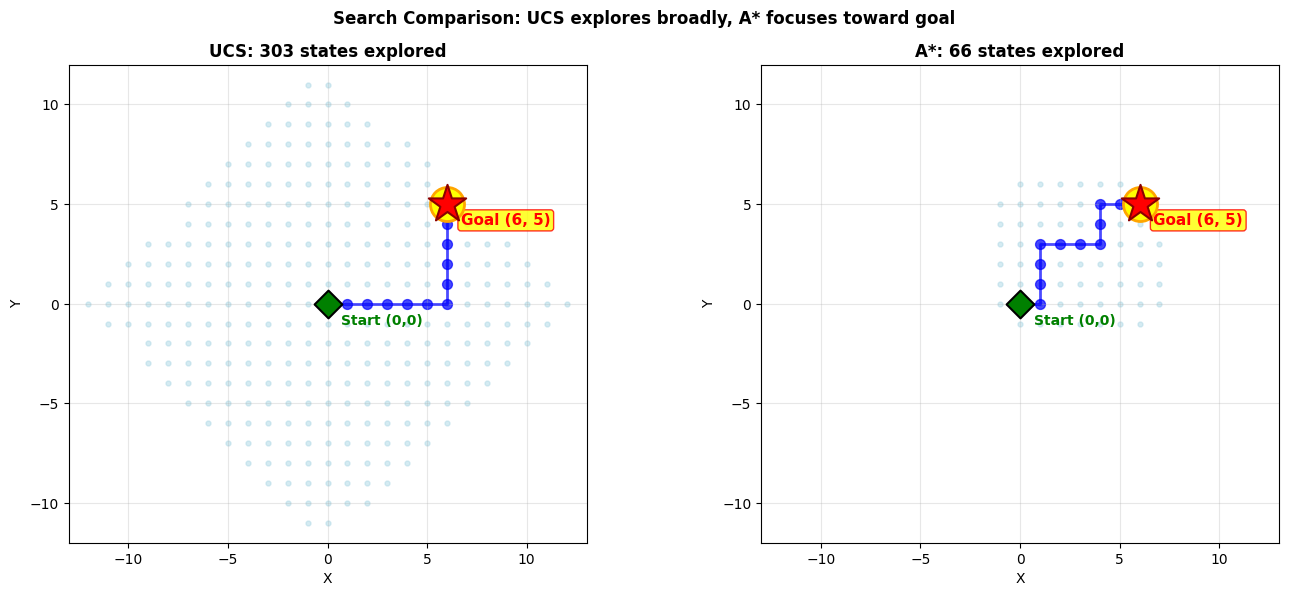

In [84]:
import matplotlib.pyplot as plt
import time

# Re-run to capture search frontiers
def get_search_frontier(searcher_fn):
    """Run search and return the frontier (reached states)."""
    prob = grid
    node = Node(prob.initial)
    frontier = PriorityQueue([node], key=lambda n: n.path_cost if searcher_fn == uniform_cost_search 
                                                    else (n.path_cost + prob.h(n)))
    reached = {prob.initial: node}
    while frontier:
        node = frontier.pop()
        if prob.is_goal(node.state): break
        for child in expand(prob, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return reached.keys()

ucs_frontier = get_search_frontier(uniform_cost_search)
astar_frontier = get_search_frontier(astar_search)

# Compute axis limits from actual data
all_states = set(ucs_frontier) | set(astar_frontier) | {grid.initial, grid.goal}
all_x = [s[0] for s in all_states]
all_y = [s[1] for s in all_states]
x_min, x_max = min(all_x) - 1, max(all_x) + 1
y_min, y_max = min(all_y) - 1, max(all_y) + 1

# Visualize both searches side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for ax, frontier, title in [
    (ax1, ucs_frontier, f'UCS: {len(ucs_frontier)} states explored'),
    (ax2, astar_frontier, f'A*: {len(astar_frontier)} states explored')
]:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title, fontsize=12, fontweight='bold')
    
    # Plot reached states
    if frontier:
        fx, fy = zip(*frontier)
        ax.scatter(fx, fy, marker='.', s=50, c='lightblue', alpha=0.5)
    
    # Plot solution path
    path = list(path_states(ucs_sol if 'UCS' in title else astar_sol))
    if path:
        px, py = zip(*path)
        ax.plot(px, py, 'b-', linewidth=2, alpha=0.7)
        ax.scatter(px, py, c='blue', s=50, alpha=0.7)
    
    # Start marker with label
    ax.scatter(*grid.initial, marker='D', s=200, c='green', edgecolors='black', linewidths=1.5, zorder=5)
    ax.annotate('Start (0,0)', grid.initial, textcoords="offset points", xytext=(10, -15),
                fontsize=10, fontweight='bold', color='green')
    
    # Goal marker with label - yellow halo + red star
    ax.scatter(*grid.goal, marker='o', s=600, c='yellow', edgecolors='orange', linewidths=2, zorder=4)
    ax.scatter(*grid.goal, marker='*', s=800, c='red', edgecolors='darkred', linewidths=1.5, zorder=5)
    ax.annotate(f'Goal {grid.goal}', grid.goal, textcoords="offset points", xytext=(10, -15),
                fontsize=11, fontweight='bold', color='red',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', edgecolor='red', alpha=0.8))

plt.suptitle('Search Comparison: UCS explores broadly, A* focuses toward goal', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()